# Library Import

In [1]:
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Network Components Definition

In [2]:
class DenseLayer:
    def __init__(self, input_dim, output_dim):
        self.W = np.random.randn(input_dim + 1, output_dim) * np.sqrt(2.0 / input_dim)
        self.dW = None
        self.cache = None

    def forward(self, X):
        X_with_bias = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
        self.cache = X_with_bias
        return np.dot(X_with_bias, self.W)

    def backward(self, dout):
        X_with_bias = self.cache
        self.dW = np.dot(X_with_bias.T, dout)
        dX = np.dot(dout, self.W.T)[:, :-1]
        return dX

    def get_params(self):
        return {'W': self.W}

    def get_grads(self):
        return {'W': self.dW}

In [3]:
class BatchNormalization:
    def __init__(self, input_dim, epsilon=1e-5, momentum=0.9):
        self.gamma = np.ones((1, input_dim))
        self.beta = np.zeros((1, input_dim))
        self.epsilon = epsilon
        self.momentum = momentum
        self.running_mean = np.zeros((1, input_dim))
        self.running_var = np.ones((1, input_dim))
        self.cache = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, X, mode='train'):
        if mode == 'train':
            mean = np.mean(X, axis=0)
            var = np.var(X, axis=0)
            X_norm = (X - mean) / np.sqrt(var + self.epsilon)
            out = self.gamma * X_norm + self.beta

            self.cache = (X, X_norm, mean, var)

            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var
        else:
            X_norm = (X - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
            out = self.gamma * X_norm + self.beta

        return out

    def backward(self, dout):
        X, X_norm, mean, var = self.cache
        N, D = X.shape

        self.dgamma = np.sum(dout * X_norm, axis=0)
        self.dbeta = np.sum(dout, axis=0)

        dX_norm = dout * self.gamma

        dvar = np.sum(dX_norm * (X - mean) * -0.5 * (var + self.epsilon) ** -1.5, axis=0)
        dmean = np.sum(dX_norm * -1.0 / np.sqrt(var + self.epsilon), axis=0) + dvar * np.sum(-2.0 * (X - mean), axis=0) / N
        dX = dX_norm / np.sqrt(var + self.epsilon) + dvar * 2.0 * (X - mean) / N + dmean / N

        return dX

    def get_params(self):
        return {'gamma': self.gamma, 'beta': self.beta}

    def get_grads(self):
        return {'gamma': self.dgamma, 'beta': self.dbeta}

In [4]:
class ReLU:
    def __init__(self):
        self.cache = None

    def forward(self, X):
        self.cache = X
        return np.maximum(0, X)

    def backward(self, dout):
        X = self.cache
        dX = dout * (X > 0)
        return dX

In [5]:
class Dropout:
    def __init__(self, dropout_rate=0.5):
        self.dropout_rate = dropout_rate
        self.mask = None

    def forward(self, X, mode='train'):
        if mode == 'train':
            self.mask = (np.random.rand(*X.shape) > self.dropout_rate) / (1 - self.dropout_rate)
            return X * self.mask
        else:
            return X  # No dropout during testing

    def backward(self, dout):
        return dout * self.mask

In [6]:
class Softmax:
    def __init__(self):
        self.cache = None

    def forward(self, X):
        exps = np.exp(X - np.max(X, axis=1, keepdims=True))
        self.cache = exps / np.sum(exps, axis=1, keepdims=True)
        return self.cache

    def backward(self, dout):
        return dout

In [7]:
class CrossEntropyLoss:
    def __init__(self):
        self.probs = None
        self.labels = None

    def forward(self, logits, labels):
        self.probs = logits
        self.labels = labels
        N = logits.shape[0]
        loss = -np.sum(labels * np.log(self.probs + 1e-8)) / N
        return loss

    def backward(self):
        N = self.labels.shape[0]
        dlogits = (self.probs - self.labels) / N
        return dlogits

In [8]:
class AdamOptimizer:
    def __init__(self, layers, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.layers = layers
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0  # time step
        self.m = {}
        self.v = {}
        self.initialize_moments()

    def initialize_moments(self):
        for layer in self.layers:
            if hasattr(layer, 'get_params'):
                params = layer.get_params()
                self.m[layer] = {key: np.zeros_like(val) for key, val in params.items()}
                self.v[layer] = {key: np.zeros_like(val) for key, val in params.items()}

    def update_params(self):
        self.t += 1
        for layer in self.layers:
            if hasattr(layer, 'get_params'):
                params = layer.get_params()
                grads = layer.get_grads()

                for key in params:
                    self.m[layer][key] = self.beta1 * self.m[layer][key] + (1 - self.beta1) * grads[key]
                    self.v[layer][key] = self.beta2 * self.v[layer][key] + (1 - self.beta2) * (grads[key] ** 2)

                    # Bias correction
                    m_hat = self.m[layer][key] / (1 - self.beta1 ** self.t)
                    v_hat = self.v[layer][key] / (1 - self.beta2 ** self.t)

                    # Update parameters
                    params[key] -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)



In [9]:
class NeuralNetwork:
    def __init__(self, layers, num_epochs=10, batch_size=64, learning_rate=0.0001, optimizer=None, loss_function=None):
        self.layers = layers
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        # default to Adam
        self.optimizer = optimizer if optimizer is not None else AdamOptimizer(layers, learning_rate=self.learning_rate)
        
        # default to CrossEntropyLoss
        self.loss_function = loss_function if loss_function is not None else CrossEntropyLoss()

        # Initialize history for metrics
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.val_macro_f1_history = []

    def forward(self, X, mode='train'):
        out = X
        for layer in self.layers:
            if isinstance(layer, (Dropout, BatchNormalization)):
                out = layer.forward(out, mode)
            else:
                out = layer.forward(out)
        return out

    def backward(self, d_out):
        for layer in reversed(self.layers):
            d_out = layer.backward(d_out)

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        num_batches = X_train.shape[0] // self.batch_size

        for epoch in range(self.num_epochs):
            # Shuffle the training data
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train = X_train[indices]
            y_train = y_train[indices]

            epoch_loss = 0
            epoch_acc = 0

            for i in tqdm(range(num_batches)):
                # Get the mini-batch
                start = i * self.batch_size
                end = start + self.batch_size
                X_batch = X_train[start:end]
                y_batch = y_train[start:end]

                # Forward pass
                logits = self.forward(X_batch, mode='train')
                loss = self.loss_function.forward(logits, y_batch)
                epoch_loss += loss

                # Compute accuracy
                predictions = np.argmax(logits, axis=1)
                labels = np.argmax(y_batch, axis=1)
                acc = np.mean(predictions == labels)
                epoch_acc += acc

                # Backward pass
                d_logits = self.loss_function.backward()
                self.backward(d_logits)

                # Update parameters using the optimizer
                self.optimizer.update_params()

            # Calculate epoch averages
            epoch_loss /= num_batches
            epoch_acc /= num_batches

            # Append to history
            self.train_loss_history.append(epoch_loss)
            self.train_acc_history.append(epoch_acc)

            # Validation if available
            if X_val is not None and y_val is not None:
                val_loss, val_acc, val_macro_f1 = self.evaluate(X_val, y_val)
                self.val_loss_history.append(val_loss)
                self.val_acc_history.append(val_acc)
                self.val_macro_f1_history.append(val_macro_f1)

                print(f"Epoch {epoch+1}/{self.num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, "
                      f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val Macro F1: {val_macro_f1:.4f}")
            else:
                print(f"Epoch {epoch+1}/{self.num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")

    def evaluate(self, X_val, y_val):
        # Forward pass for validation
        logits_val = self.forward(X_val, mode='test')
        
        # Validation loss
        val_loss = self.loss_function.forward(logits_val, y_val)

        # Compute accuracy
        val_predictions = np.argmax(logits_val, axis=1)
        val_labels = np.argmax(y_val, axis=1)
        val_acc = np.mean(val_predictions == val_labels)

        # Compute Macro F1 Score
        val_macro_f1 = f1_score(val_labels, val_predictions, average='macro')

        return val_loss, val_acc, val_macro_f1

    def predict(self, X_test):
        logits_test = self.forward(X_test, mode='test')
        test_predictions = np.argmax(logits_test, axis=1)
        return test_predictions

# Model Building

In [10]:
def build_model(config):
    """
    This function:
    - Takes a configuration dictionary as input.
    - Builds a neural network model based on the provided configuration.
    - Returns the constructed NeuralNetwork object
    """

    layers = []
    input_dim = 784
    
    for layer_config in config['hidden_layers']:
        layer_size = layer_config['size']
        
        layers.append(DenseLayer(input_dim, layer_size))
        if layer_config.get('bn', False):
            layers.append(BatchNormalization(layer_size))
        if layer_config.get('relu', False):
            layers.append(ReLU())
        if layer_config.get('dropout', 0) > 0:
            layers.append(Dropout(dropout_rate=layer_config['dropout']))
            
        input_dim = layer_size
        
    layers.append(DenseLayer(input_dim, 10))
    layers.append(Softmax())

    # Create the NeuralNetwork object
    model = NeuralNetwork(layers, learning_rate=config['learning_rate'],num_epochs=config['num_epochs'], batch_size=config['batch_size'])
    return model

In [11]:
# Save model function
def save_model(config, neural_network, file_path):
    layer_index = 0

    # Go through each hidden layer config
    for i, layer_config in enumerate(config['hidden_layers']):
        dense_layer = neural_network.layers[layer_index]
        if isinstance(dense_layer, DenseLayer):
            layer_config['W'] = dense_layer.W
        
        layer_index += 1
        
        if layer_config.get('bn', False):
            bn_layer = neural_network.layers[layer_index]
            if isinstance(bn_layer, BatchNormalization):
                layer_config['running_mean'] = bn_layer.running_mean
                layer_config['running_var'] = bn_layer.running_var
                layer_config['epsilon'] = bn_layer.epsilon
                layer_config['gamma'] = bn_layer.gamma
                layer_config['beta'] = bn_layer.beta
            
            layer_index += 1
        
        if layer_config.get('relu', False):
            relu_layer = neural_network.layers[layer_index]
            if isinstance(relu_layer, ReLU):
                layer_index += 1
        
        if layer_config.get('dropout', 0) > 0:
            dropout_layer = neural_network.layers[layer_index]
            if isinstance(dropout_layer, Dropout):
                layer_index += 1
    
    output_layer = neural_network.layers[layer_index]
    if isinstance(output_layer, DenseLayer):
        config['output_layer_W'] = output_layer.W
    
    with open(file_path, 'wb') as f:
        pickle.dump(config, f)
    
    print(f"Model saved to {file_path}")

In [12]:
# Load model function
def load_model(file_path):
    with open(file_path, 'rb') as f:
        config = pickle.load(f)
    
    # Build the model using the config
    neural_network = build_model(config)
    
    layer_index = 0 
    
    for i, layer_config in enumerate(config['hidden_layers']):
        dense_layer = neural_network.layers[layer_index]
        if isinstance(dense_layer, DenseLayer):
            dense_layer.W = layer_config['W']
        
        layer_index += 1
        
        if layer_config.get('bn', False):
            bn_layer = neural_network.layers[layer_index]
            if isinstance(bn_layer, BatchNormalization):
                bn_layer.running_mean = layer_config['running_mean']
                bn_layer.running_var = layer_config['running_var']
                bn_layer.epsilon = layer_config['epsilon']
                bn_layer.gamma = layer_config['gamma']
                bn_layer.beta = layer_config['beta']
            
            layer_index += 1
        
        if layer_config.get('relu', False):
            relu_layer = neural_network.layers[layer_index]
            if isinstance(relu_layer, ReLU):
                layer_index += 1
        
        if layer_config.get('dropout', 0) > 0:
            dropout_layer = neural_network.layers[layer_index]
            if isinstance(dropout_layer, Dropout):
                layer_index += 1
    
    output_layer = neural_network.layers[layer_index]
    if isinstance(output_layer, DenseLayer):
        output_layer.W = config['output_layer_W']
    
    print("Model loaded from file")
    return neural_network

In [13]:
import matplotlib.pyplot as plt

def plot_model_history(model):
    """
    This function takes a NeuralNetwork model object and plots:
    - Training Loss History
    - Validation Loss History
    - Training Accuracy History
    - Validation Accuracy History
    - Validation Macro-F1 Score History
    """
    
    train_loss_history = model.train_loss_history
    val_loss_history = model.val_loss_history
    train_acc_history = model.train_acc_history
    val_acc_history = model.val_acc_history
    val_macro_f1_history = model.val_macro_f1_history

    epochs = range(1, len(train_loss_history) + 1)

    plt.figure(figsize=(12, 8))
    
    plt.plot(epochs, train_loss_history, label='Training Loss', color='blue')
    plt.plot(epochs, train_acc_history, label='Training Accuracy', color='green')
    if len(val_acc_history)>0:
        plt.plot(epochs, val_acc_history, label='Validation Accuracy', color='red')
        plt.plot(epochs, val_loss_history, label='Validation Loss', color='orange')
        plt.plot(epochs, val_macro_f1_history, label='Validation Macro-F1 Score', color='purple')

    plt.title('Model Performance Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Values')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


In [14]:
def plot_models_history(models):
    """
    This function takes a list of NeuralNetwork model objects and plots their
    train_loss_history, val_loss_history, train_acc_history, val_acc_history, and val_macro_f1_history
    in a single figure with five subplots.
    """
    labels = [f"Model {i+1}" for i in range(len(models))]
    epochs = range(1, len(models[0].train_loss_history) + 1)

    plt.figure(figsize=(18, 15))

    # Subplot 1: Train Loss
    plt.subplot(3, 2, 1)
    for i, model in enumerate(models):
        plt.plot(epochs, model.train_loss_history, label=labels[i])
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Subplot 2: Validation Loss
    plt.subplot(3, 2, 2)
    for i, model in enumerate(models):
        plt.plot(epochs, model.val_loss_history, label=labels[i])
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Subplot 3: Train Accuracy
    plt.subplot(3, 2, 3)
    for i, model in enumerate(models):
        plt.plot(epochs, model.train_acc_history, label=labels[i])
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Subplot 4: Validation Accuracy
    plt.subplot(3, 2, 4)
    for i, model in enumerate(models):
        plt.plot(epochs, model.val_acc_history, label=labels[i])
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Subplot 5: Validation Macro F1-Score
    plt.subplot(3, 2, 5)
    for i, model in enumerate(models):
        plt.plot(epochs, model.val_macro_f1_history, label=labels[i])
    plt.title('Validation Macro F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Macro F1')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [15]:
def train_and_evaluate_models(configs, train_data, train_labels, val_data, val_labels,val_y,best_f1=-1,best_model=None,best_config=None):
    """
    This function:
    - Takes a list of configs.
    - Builds models using the build_model function.
    - Trains each model and collects their histories.
    - Plots the performance metrics.
    - Returns the best model based on validation macro-F1 score.
    """

    models = []

    for config in configs:
        print(f"Trying configuration: {config}")
        # Build the model from the configuration
        model = build_model(config)

        # Train the model
        model.fit(train_data, train_labels, val_data, val_labels)
        models.append(model)
        
        print(f"For configuration: {config}")
        plot_model_history(model)
        val_loss, val_acc, val_macro_f1 = model.evaluate(val_data, val_labels)
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val Macro F1: {val_macro_f1:.4f}")

        val_predictions = model.predict(val_data)
        conf_matrix = confusion_matrix(val_y, val_predictions)
        print("Confusion Matrix:")
        print(conf_matrix)
        
        if val_macro_f1 > best_f1:
            best_f1 = val_macro_f1
            best_model = model
            best_config = config

    print("Plot:")
    plot_models_history(models)

    return best_model, best_config, best_f1

# Data Loading

In [16]:
transform = transforms.ToTensor()

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:01<00:00, 13309289.60it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210905.32it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3884508.02it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6027994.69it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# Preprocessing

In [17]:
X_train = train_dataset.data.numpy()
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()

In [18]:
print(X_test,y_test)

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]] [9 2 1 ... 8 1 5]


In [19]:
# Normalize data and flatten
X_train = X_train.reshape(-1, 28*28) / 255.0
X_test = X_test.reshape(-1, 28*28) / 255.0

In [20]:
def to_one_hot(y, num_classes):
    return np.eye(num_classes)[y]

In [21]:
# Convert labels to one-hot encoding
num_classes = 10
y_train_one_hot = to_one_hot(y_train, num_classes)
y_test_one_hot = to_one_hot(y_test, num_classes)

In [22]:
# Split training data into training and validation sets
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train_labels, y_val_labels = train_test_split(
    X_train, y_train_one_hot, y_train, test_size=0.1, random_state=42
)

# Validation

**With Three Different Architectures**

In [23]:
config_model_1 = {
    'learning_rate': 0.001,
    'num_epochs': 50,
    'batch_size': 32,
    'hidden_layers': [
        {
            'size': 512,
            'bn': True,
            'dropout': 0.3,
            'relu': True
        },
        {
            'size': 256,
            'bn': False,
            'dropout': 0.4,
            'relu': True
        },
        {
            'size': 128,
            'bn': True,
            'dropout': 0.5,
            'relu': True
        }
    ]
}

In [24]:
config_model_2 = {
    'learning_rate': 0.001,
    'num_epochs': 50,
    'batch_size': 64,
    'hidden_layers': [
        {
            'size': 512,
            'bn': False,
            'dropout': 0.3,
            'relu': True
        },
        {
            'size': 256,
            'bn': True,
            'dropout': 0.4,
            'relu': True
        }
    ]
}

In [25]:
config_model_3 = {
    'learning_rate': 0.001,
    'num_epochs': 50,
    'batch_size': 128,
    'hidden_layers': [
        {
            'size': 1024,
            'bn': True,
            'dropout': 0.3,
            'relu': True
        },
        {
            'size': 512,
            'bn': True,
            'dropout': 0.5,
            'relu': True
        }
    ]
}

Trying configuration: {'learning_rate': 0.001, 'num_epochs': 50, 'batch_size': 32, 'hidden_layers': [{'size': 512, 'bn': True, 'dropout': 0.3, 'relu': True}, {'size': 256, 'bn': False, 'dropout': 0.4, 'relu': True}, {'size': 128, 'bn': True, 'dropout': 0.5, 'relu': True}]}


100%|██████████| 1687/1687 [00:48<00:00, 34.94it/s]


Epoch 1/50, Train Loss: 0.6615, Train Accuracy: 0.7700, Val Loss: 0.4135, Val Accuracy: 0.8463, Val Macro F1: 0.8468


100%|██████████| 1687/1687 [00:46<00:00, 36.25it/s]


Epoch 2/50, Train Loss: 0.4881, Train Accuracy: 0.8301, Val Loss: 0.3554, Val Accuracy: 0.8707, Val Macro F1: 0.8726


100%|██████████| 1687/1687 [00:48<00:00, 35.04it/s]


Epoch 3/50, Train Loss: 0.4479, Train Accuracy: 0.8433, Val Loss: 0.3647, Val Accuracy: 0.8668, Val Macro F1: 0.8705


100%|██████████| 1687/1687 [00:46<00:00, 36.40it/s]


Epoch 4/50, Train Loss: 0.4160, Train Accuracy: 0.8515, Val Loss: 0.3450, Val Accuracy: 0.8762, Val Macro F1: 0.8771


100%|██████████| 1687/1687 [00:47<00:00, 35.87it/s]


Epoch 5/50, Train Loss: 0.3919, Train Accuracy: 0.8613, Val Loss: 0.3159, Val Accuracy: 0.8858, Val Macro F1: 0.8866


100%|██████████| 1687/1687 [00:47<00:00, 35.60it/s]


Epoch 6/50, Train Loss: 0.3748, Train Accuracy: 0.8663, Val Loss: 0.3280, Val Accuracy: 0.8787, Val Macro F1: 0.8794


100%|██████████| 1687/1687 [00:47<00:00, 35.76it/s]


Epoch 7/50, Train Loss: 0.3585, Train Accuracy: 0.8731, Val Loss: 0.3193, Val Accuracy: 0.8843, Val Macro F1: 0.8833


100%|██████████| 1687/1687 [00:47<00:00, 35.71it/s]


Epoch 8/50, Train Loss: 0.3484, Train Accuracy: 0.8764, Val Loss: 0.3015, Val Accuracy: 0.8878, Val Macro F1: 0.8885


100%|██████████| 1687/1687 [00:47<00:00, 35.31it/s]


Epoch 9/50, Train Loss: 0.3331, Train Accuracy: 0.8803, Val Loss: 0.2998, Val Accuracy: 0.8913, Val Macro F1: 0.8917


100%|██████████| 1687/1687 [00:46<00:00, 35.91it/s]


Epoch 10/50, Train Loss: 0.3254, Train Accuracy: 0.8835, Val Loss: 0.2971, Val Accuracy: 0.8935, Val Macro F1: 0.8946


100%|██████████| 1687/1687 [00:47<00:00, 35.77it/s]


Epoch 11/50, Train Loss: 0.3156, Train Accuracy: 0.8848, Val Loss: 0.2893, Val Accuracy: 0.8883, Val Macro F1: 0.8878


100%|██████████| 1687/1687 [00:47<00:00, 35.69it/s]


Epoch 12/50, Train Loss: 0.3092, Train Accuracy: 0.8889, Val Loss: 0.2881, Val Accuracy: 0.8955, Val Macro F1: 0.8961


100%|██████████| 1687/1687 [00:47<00:00, 35.37it/s]


Epoch 13/50, Train Loss: 0.3037, Train Accuracy: 0.8914, Val Loss: 0.2947, Val Accuracy: 0.8925, Val Macro F1: 0.8930


100%|██████████| 1687/1687 [00:48<00:00, 34.79it/s]


Epoch 14/50, Train Loss: 0.2949, Train Accuracy: 0.8923, Val Loss: 0.2901, Val Accuracy: 0.8945, Val Macro F1: 0.8944


100%|██████████| 1687/1687 [00:46<00:00, 36.21it/s]


Epoch 15/50, Train Loss: 0.2864, Train Accuracy: 0.8972, Val Loss: 0.2954, Val Accuracy: 0.8918, Val Macro F1: 0.8902


100%|██████████| 1687/1687 [00:47<00:00, 35.52it/s]


Epoch 16/50, Train Loss: 0.2791, Train Accuracy: 0.8992, Val Loss: 0.2817, Val Accuracy: 0.8958, Val Macro F1: 0.8956


100%|██████████| 1687/1687 [00:47<00:00, 35.32it/s]


Epoch 17/50, Train Loss: 0.2716, Train Accuracy: 0.9016, Val Loss: 0.2845, Val Accuracy: 0.8983, Val Macro F1: 0.8981


100%|██████████| 1687/1687 [00:48<00:00, 34.86it/s]


Epoch 18/50, Train Loss: 0.2661, Train Accuracy: 0.9038, Val Loss: 0.2809, Val Accuracy: 0.8975, Val Macro F1: 0.8979


100%|██████████| 1687/1687 [00:49<00:00, 34.28it/s]


Epoch 19/50, Train Loss: 0.2642, Train Accuracy: 0.9057, Val Loss: 0.2830, Val Accuracy: 0.8973, Val Macro F1: 0.8977


100%|██████████| 1687/1687 [00:46<00:00, 36.47it/s]


Epoch 20/50, Train Loss: 0.2573, Train Accuracy: 0.9062, Val Loss: 0.2823, Val Accuracy: 0.8950, Val Macro F1: 0.8959


100%|██████████| 1687/1687 [00:49<00:00, 34.32it/s]


Epoch 21/50, Train Loss: 0.2572, Train Accuracy: 0.9074, Val Loss: 0.2822, Val Accuracy: 0.8975, Val Macro F1: 0.8976


100%|██████████| 1687/1687 [00:47<00:00, 35.72it/s]


Epoch 22/50, Train Loss: 0.2457, Train Accuracy: 0.9096, Val Loss: 0.2761, Val Accuracy: 0.8998, Val Macro F1: 0.9004


100%|██████████| 1687/1687 [00:48<00:00, 34.46it/s]


Epoch 23/50, Train Loss: 0.2437, Train Accuracy: 0.9116, Val Loss: 0.2886, Val Accuracy: 0.8993, Val Macro F1: 0.8998


100%|██████████| 1687/1687 [00:47<00:00, 35.78it/s]


Epoch 24/50, Train Loss: 0.2396, Train Accuracy: 0.9122, Val Loss: 0.2916, Val Accuracy: 0.8953, Val Macro F1: 0.8962


100%|██████████| 1687/1687 [00:48<00:00, 34.73it/s]


Epoch 25/50, Train Loss: 0.2365, Train Accuracy: 0.9136, Val Loss: 0.2839, Val Accuracy: 0.8983, Val Macro F1: 0.8999


100%|██████████| 1687/1687 [00:48<00:00, 35.08it/s]


Epoch 26/50, Train Loss: 0.2310, Train Accuracy: 0.9148, Val Loss: 0.2878, Val Accuracy: 0.8978, Val Macro F1: 0.8984


100%|██████████| 1687/1687 [00:48<00:00, 34.63it/s]


Epoch 27/50, Train Loss: 0.2289, Train Accuracy: 0.9166, Val Loss: 0.2774, Val Accuracy: 0.9013, Val Macro F1: 0.9012


100%|██████████| 1687/1687 [00:47<00:00, 35.59it/s]


Epoch 28/50, Train Loss: 0.2251, Train Accuracy: 0.9186, Val Loss: 0.2820, Val Accuracy: 0.8993, Val Macro F1: 0.9007


100%|██████████| 1687/1687 [00:49<00:00, 34.22it/s]


Epoch 29/50, Train Loss: 0.2215, Train Accuracy: 0.9191, Val Loss: 0.2739, Val Accuracy: 0.9008, Val Macro F1: 0.9019


100%|██████████| 1687/1687 [00:48<00:00, 35.09it/s]


Epoch 30/50, Train Loss: 0.2208, Train Accuracy: 0.9197, Val Loss: 0.2811, Val Accuracy: 0.8990, Val Macro F1: 0.9000


100%|██████████| 1687/1687 [00:47<00:00, 35.47it/s]


Epoch 31/50, Train Loss: 0.2164, Train Accuracy: 0.9217, Val Loss: 0.2835, Val Accuracy: 0.9025, Val Macro F1: 0.9023


100%|██████████| 1687/1687 [00:49<00:00, 34.39it/s]


Epoch 32/50, Train Loss: 0.2127, Train Accuracy: 0.9234, Val Loss: 0.2740, Val Accuracy: 0.9030, Val Macro F1: 0.9039


100%|██████████| 1687/1687 [00:47<00:00, 35.19it/s]


Epoch 33/50, Train Loss: 0.2121, Train Accuracy: 0.9233, Val Loss: 0.2927, Val Accuracy: 0.9002, Val Macro F1: 0.9004


100%|██████████| 1687/1687 [00:50<00:00, 33.69it/s]


Epoch 34/50, Train Loss: 0.2075, Train Accuracy: 0.9247, Val Loss: 0.2757, Val Accuracy: 0.9043, Val Macro F1: 0.9048


100%|██████████| 1687/1687 [00:48<00:00, 35.06it/s]


Epoch 35/50, Train Loss: 0.2031, Train Accuracy: 0.9260, Val Loss: 0.2954, Val Accuracy: 0.9010, Val Macro F1: 0.9010


100%|██████████| 1687/1687 [00:49<00:00, 33.99it/s]


Epoch 36/50, Train Loss: 0.2024, Train Accuracy: 0.9283, Val Loss: 0.2940, Val Accuracy: 0.8988, Val Macro F1: 0.9000


100%|██████████| 1687/1687 [00:46<00:00, 36.00it/s]


Epoch 37/50, Train Loss: 0.1998, Train Accuracy: 0.9275, Val Loss: 0.2874, Val Accuracy: 0.9032, Val Macro F1: 0.9037


100%|██████████| 1687/1687 [00:49<00:00, 34.10it/s]


Epoch 38/50, Train Loss: 0.1997, Train Accuracy: 0.9282, Val Loss: 0.2924, Val Accuracy: 0.9013, Val Macro F1: 0.9026


100%|██████████| 1687/1687 [00:47<00:00, 35.66it/s]


Epoch 39/50, Train Loss: 0.1943, Train Accuracy: 0.9294, Val Loss: 0.2883, Val Accuracy: 0.9052, Val Macro F1: 0.9059


100%|██████████| 1687/1687 [00:47<00:00, 35.68it/s]


Epoch 40/50, Train Loss: 0.1909, Train Accuracy: 0.9303, Val Loss: 0.2826, Val Accuracy: 0.9052, Val Macro F1: 0.9052


100%|██████████| 1687/1687 [00:47<00:00, 35.24it/s]


Epoch 41/50, Train Loss: 0.1917, Train Accuracy: 0.9304, Val Loss: 0.2889, Val Accuracy: 0.8988, Val Macro F1: 0.9002


100%|██████████| 1687/1687 [00:48<00:00, 34.90it/s]


Epoch 42/50, Train Loss: 0.1896, Train Accuracy: 0.9320, Val Loss: 0.2907, Val Accuracy: 0.9038, Val Macro F1: 0.9041


100%|██████████| 1687/1687 [00:47<00:00, 35.25it/s]


Epoch 43/50, Train Loss: 0.1895, Train Accuracy: 0.9308, Val Loss: 0.2862, Val Accuracy: 0.9057, Val Macro F1: 0.9065


100%|██████████| 1687/1687 [00:48<00:00, 34.67it/s]


Epoch 44/50, Train Loss: 0.1836, Train Accuracy: 0.9325, Val Loss: 0.2946, Val Accuracy: 0.9023, Val Macro F1: 0.9035


100%|██████████| 1687/1687 [00:47<00:00, 35.42it/s]


Epoch 45/50, Train Loss: 0.1816, Train Accuracy: 0.9338, Val Loss: 0.3060, Val Accuracy: 0.9008, Val Macro F1: 0.9007


100%|██████████| 1687/1687 [00:49<00:00, 34.40it/s]


Epoch 46/50, Train Loss: 0.1786, Train Accuracy: 0.9330, Val Loss: 0.2959, Val Accuracy: 0.9015, Val Macro F1: 0.9011


100%|██████████| 1687/1687 [00:47<00:00, 35.38it/s]


Epoch 47/50, Train Loss: 0.1788, Train Accuracy: 0.9358, Val Loss: 0.2974, Val Accuracy: 0.9040, Val Macro F1: 0.9040


100%|██████████| 1687/1687 [00:49<00:00, 34.20it/s]


Epoch 48/50, Train Loss: 0.1747, Train Accuracy: 0.9369, Val Loss: 0.2984, Val Accuracy: 0.9012, Val Macro F1: 0.9028


100%|██████████| 1687/1687 [00:48<00:00, 35.08it/s]


Epoch 49/50, Train Loss: 0.1715, Train Accuracy: 0.9375, Val Loss: 0.2888, Val Accuracy: 0.9043, Val Macro F1: 0.9052


100%|██████████| 1687/1687 [00:47<00:00, 35.24it/s]


Epoch 50/50, Train Loss: 0.1723, Train Accuracy: 0.9366, Val Loss: 0.2961, Val Accuracy: 0.9028, Val Macro F1: 0.9039
For configuration: {'learning_rate': 0.001, 'num_epochs': 50, 'batch_size': 32, 'hidden_layers': [{'size': 512, 'bn': True, 'dropout': 0.3, 'relu': True}, {'size': 256, 'bn': False, 'dropout': 0.4, 'relu': True}, {'size': 128, 'bn': True, 'dropout': 0.5, 'relu': True}]}


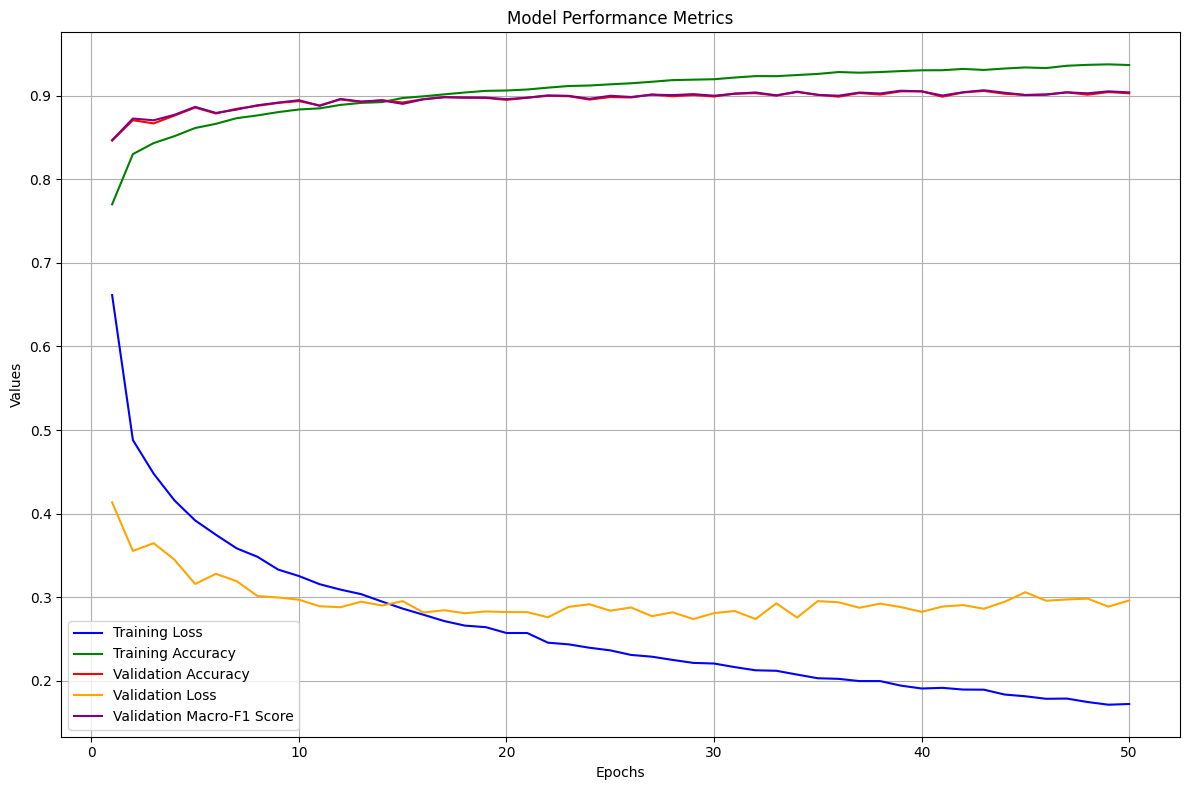

Val Loss: 0.2961, Val Accuracy: 0.9028, Val Macro F1: 0.9039
Confusion Matrix:
[[513   2   8   9   2   0  61   0   2   0]
 [  1 598   0   9   0   0   0   0   0   0]
 [ 11   0 535   4  26   0  35   0   0   0]
 [ 20   3   2 531  19   0   8   0   4   0]
 [  1   0  46  11 521   1  44   0   3   0]
 [  0   0   0   0   0 607   0  10   0   4]
 [ 74   0  49  13  19   0 458   0   6   0]
 [  0   0   0   0   0  11   0 532   0   7]
 [  0   1   5   2   3   1   6   1 571   0]
 [  0   0   0   0   0  10   0  29   0 551]]
Trying configuration: {'learning_rate': 0.001, 'num_epochs': 50, 'batch_size': 64, 'hidden_layers': [{'size': 512, 'bn': False, 'dropout': 0.3, 'relu': True}, {'size': 256, 'bn': True, 'dropout': 0.4, 'relu': True}]}


100%|██████████| 843/843 [00:23<00:00, 35.75it/s]


Epoch 1/50, Train Loss: 0.5790, Train Accuracy: 0.7921, Val Loss: 0.3958, Val Accuracy: 0.8518, Val Macro F1: 0.8529


100%|██████████| 843/843 [00:25<00:00, 33.44it/s]


Epoch 2/50, Train Loss: 0.4330, Train Accuracy: 0.8441, Val Loss: 0.3705, Val Accuracy: 0.8657, Val Macro F1: 0.8648


100%|██████████| 843/843 [00:24<00:00, 33.87it/s]


Epoch 3/50, Train Loss: 0.3921, Train Accuracy: 0.8554, Val Loss: 0.3385, Val Accuracy: 0.8737, Val Macro F1: 0.8742


100%|██████████| 843/843 [00:22<00:00, 37.02it/s]


Epoch 4/50, Train Loss: 0.3697, Train Accuracy: 0.8649, Val Loss: 0.3350, Val Accuracy: 0.8740, Val Macro F1: 0.8744


100%|██████████| 843/843 [00:23<00:00, 35.18it/s]


Epoch 5/50, Train Loss: 0.3520, Train Accuracy: 0.8707, Val Loss: 0.3302, Val Accuracy: 0.8810, Val Macro F1: 0.8823


100%|██████████| 843/843 [00:24<00:00, 33.80it/s]


Epoch 6/50, Train Loss: 0.3386, Train Accuracy: 0.8734, Val Loss: 0.3190, Val Accuracy: 0.8803, Val Macro F1: 0.8808


100%|██████████| 843/843 [00:23<00:00, 36.20it/s]


Epoch 7/50, Train Loss: 0.3258, Train Accuracy: 0.8793, Val Loss: 0.3369, Val Accuracy: 0.8793, Val Macro F1: 0.8798


100%|██████████| 843/843 [00:25<00:00, 33.55it/s]


Epoch 8/50, Train Loss: 0.3183, Train Accuracy: 0.8822, Val Loss: 0.3054, Val Accuracy: 0.8870, Val Macro F1: 0.8873


100%|██████████| 843/843 [00:26<00:00, 32.35it/s]


Epoch 9/50, Train Loss: 0.3077, Train Accuracy: 0.8857, Val Loss: 0.3058, Val Accuracy: 0.8892, Val Macro F1: 0.8896


100%|██████████| 843/843 [00:27<00:00, 30.21it/s]


Epoch 10/50, Train Loss: 0.3012, Train Accuracy: 0.8868, Val Loss: 0.3029, Val Accuracy: 0.8863, Val Macro F1: 0.8872


100%|██████████| 843/843 [00:27<00:00, 30.29it/s]


Epoch 11/50, Train Loss: 0.2922, Train Accuracy: 0.8899, Val Loss: 0.3004, Val Accuracy: 0.8905, Val Macro F1: 0.8916


100%|██████████| 843/843 [00:29<00:00, 28.48it/s]


Epoch 12/50, Train Loss: 0.2838, Train Accuracy: 0.8920, Val Loss: 0.2977, Val Accuracy: 0.8883, Val Macro F1: 0.8892


100%|██████████| 843/843 [00:30<00:00, 27.82it/s]


Epoch 13/50, Train Loss: 0.2803, Train Accuracy: 0.8951, Val Loss: 0.2996, Val Accuracy: 0.8882, Val Macro F1: 0.8883


100%|██████████| 843/843 [00:31<00:00, 26.64it/s]


Epoch 14/50, Train Loss: 0.2759, Train Accuracy: 0.8962, Val Loss: 0.2872, Val Accuracy: 0.8957, Val Macro F1: 0.8967


100%|██████████| 843/843 [00:32<00:00, 25.56it/s]


Epoch 15/50, Train Loss: 0.2690, Train Accuracy: 0.8979, Val Loss: 0.2860, Val Accuracy: 0.8953, Val Macro F1: 0.8959


100%|██████████| 843/843 [00:33<00:00, 25.07it/s]


Epoch 16/50, Train Loss: 0.2661, Train Accuracy: 0.9004, Val Loss: 0.2972, Val Accuracy: 0.8917, Val Macro F1: 0.8923


100%|██████████| 843/843 [00:33<00:00, 25.00it/s]


Epoch 17/50, Train Loss: 0.2598, Train Accuracy: 0.9022, Val Loss: 0.2855, Val Accuracy: 0.8947, Val Macro F1: 0.8952


100%|██████████| 843/843 [00:33<00:00, 25.40it/s]


Epoch 18/50, Train Loss: 0.2541, Train Accuracy: 0.9030, Val Loss: 0.2899, Val Accuracy: 0.8955, Val Macro F1: 0.8960


100%|██████████| 843/843 [00:34<00:00, 24.62it/s]


Epoch 19/50, Train Loss: 0.2531, Train Accuracy: 0.9047, Val Loss: 0.2914, Val Accuracy: 0.8948, Val Macro F1: 0.8943


100%|██████████| 843/843 [00:35<00:00, 23.66it/s]


Epoch 20/50, Train Loss: 0.2460, Train Accuracy: 0.9076, Val Loss: 0.2823, Val Accuracy: 0.8975, Val Macro F1: 0.8987


100%|██████████| 843/843 [00:35<00:00, 23.51it/s]


Epoch 21/50, Train Loss: 0.2478, Train Accuracy: 0.9061, Val Loss: 0.2785, Val Accuracy: 0.8995, Val Macro F1: 0.9000


100%|██████████| 843/843 [00:36<00:00, 23.19it/s]


Epoch 22/50, Train Loss: 0.2392, Train Accuracy: 0.9098, Val Loss: 0.2778, Val Accuracy: 0.8975, Val Macro F1: 0.8984


100%|██████████| 843/843 [00:35<00:00, 23.65it/s]


Epoch 23/50, Train Loss: 0.2361, Train Accuracy: 0.9110, Val Loss: 0.2840, Val Accuracy: 0.8965, Val Macro F1: 0.8973


100%|██████████| 843/843 [00:38<00:00, 22.17it/s]


Epoch 24/50, Train Loss: 0.2331, Train Accuracy: 0.9116, Val Loss: 0.2867, Val Accuracy: 0.9007, Val Macro F1: 0.9015


100%|██████████| 843/843 [00:37<00:00, 22.65it/s]


Epoch 25/50, Train Loss: 0.2276, Train Accuracy: 0.9131, Val Loss: 0.2889, Val Accuracy: 0.8945, Val Macro F1: 0.8960


100%|██████████| 843/843 [00:37<00:00, 22.32it/s]


Epoch 26/50, Train Loss: 0.2280, Train Accuracy: 0.9137, Val Loss: 0.2836, Val Accuracy: 0.8978, Val Macro F1: 0.8987


100%|██████████| 843/843 [00:37<00:00, 22.37it/s]


Epoch 27/50, Train Loss: 0.2248, Train Accuracy: 0.9146, Val Loss: 0.2781, Val Accuracy: 0.8978, Val Macro F1: 0.8981


100%|██████████| 843/843 [00:37<00:00, 22.65it/s]


Epoch 28/50, Train Loss: 0.2208, Train Accuracy: 0.9166, Val Loss: 0.2827, Val Accuracy: 0.8998, Val Macro F1: 0.9004


100%|██████████| 843/843 [00:37<00:00, 22.40it/s]


Epoch 29/50, Train Loss: 0.2187, Train Accuracy: 0.9173, Val Loss: 0.2821, Val Accuracy: 0.9000, Val Macro F1: 0.9010


100%|██████████| 843/843 [00:37<00:00, 22.24it/s]


Epoch 30/50, Train Loss: 0.2152, Train Accuracy: 0.9183, Val Loss: 0.2873, Val Accuracy: 0.8940, Val Macro F1: 0.8948


100%|██████████| 843/843 [00:38<00:00, 21.96it/s]


Epoch 31/50, Train Loss: 0.2115, Train Accuracy: 0.9203, Val Loss: 0.2912, Val Accuracy: 0.8957, Val Macro F1: 0.8959


100%|██████████| 843/843 [00:37<00:00, 22.70it/s]


Epoch 32/50, Train Loss: 0.2137, Train Accuracy: 0.9178, Val Loss: 0.2760, Val Accuracy: 0.9057, Val Macro F1: 0.9063


100%|██████████| 843/843 [00:38<00:00, 22.03it/s]


Epoch 33/50, Train Loss: 0.2075, Train Accuracy: 0.9215, Val Loss: 0.2974, Val Accuracy: 0.8967, Val Macro F1: 0.8972


100%|██████████| 843/843 [00:38<00:00, 22.08it/s]


Epoch 34/50, Train Loss: 0.2057, Train Accuracy: 0.9230, Val Loss: 0.2939, Val Accuracy: 0.8953, Val Macro F1: 0.8964


100%|██████████| 843/843 [00:38<00:00, 21.84it/s]


Epoch 35/50, Train Loss: 0.2025, Train Accuracy: 0.9224, Val Loss: 0.2897, Val Accuracy: 0.9012, Val Macro F1: 0.9018


100%|██████████| 843/843 [00:38<00:00, 21.77it/s]


Epoch 36/50, Train Loss: 0.2002, Train Accuracy: 0.9234, Val Loss: 0.2933, Val Accuracy: 0.8968, Val Macro F1: 0.8977


100%|██████████| 843/843 [00:39<00:00, 21.33it/s]


Epoch 37/50, Train Loss: 0.1999, Train Accuracy: 0.9234, Val Loss: 0.2880, Val Accuracy: 0.9010, Val Macro F1: 0.9018


100%|██████████| 843/843 [00:37<00:00, 22.21it/s]


Epoch 38/50, Train Loss: 0.1944, Train Accuracy: 0.9253, Val Loss: 0.2923, Val Accuracy: 0.8982, Val Macro F1: 0.8992


100%|██████████| 843/843 [00:38<00:00, 22.10it/s]


Epoch 39/50, Train Loss: 0.1961, Train Accuracy: 0.9249, Val Loss: 0.2960, Val Accuracy: 0.8970, Val Macro F1: 0.8973


100%|██████████| 843/843 [00:38<00:00, 22.11it/s]


Epoch 40/50, Train Loss: 0.1914, Train Accuracy: 0.9269, Val Loss: 0.2789, Val Accuracy: 0.9008, Val Macro F1: 0.9015


100%|██████████| 843/843 [00:38<00:00, 21.95it/s]


Epoch 41/50, Train Loss: 0.1900, Train Accuracy: 0.9264, Val Loss: 0.2765, Val Accuracy: 0.8992, Val Macro F1: 0.8999


100%|██████████| 843/843 [00:37<00:00, 22.53it/s]


Epoch 42/50, Train Loss: 0.1906, Train Accuracy: 0.9269, Val Loss: 0.2834, Val Accuracy: 0.9020, Val Macro F1: 0.9032


100%|██████████| 843/843 [00:38<00:00, 22.10it/s]


Epoch 43/50, Train Loss: 0.1860, Train Accuracy: 0.9291, Val Loss: 0.2839, Val Accuracy: 0.9008, Val Macro F1: 0.9014


100%|██████████| 843/843 [00:38<00:00, 21.67it/s]


Epoch 44/50, Train Loss: 0.1853, Train Accuracy: 0.9293, Val Loss: 0.2853, Val Accuracy: 0.9037, Val Macro F1: 0.9042


100%|██████████| 843/843 [00:37<00:00, 22.62it/s]


Epoch 45/50, Train Loss: 0.1848, Train Accuracy: 0.9285, Val Loss: 0.2796, Val Accuracy: 0.9032, Val Macro F1: 0.9042


100%|██████████| 843/843 [00:39<00:00, 21.50it/s]


Epoch 46/50, Train Loss: 0.1800, Train Accuracy: 0.9313, Val Loss: 0.2978, Val Accuracy: 0.8997, Val Macro F1: 0.9002


100%|██████████| 843/843 [00:37<00:00, 22.53it/s]


Epoch 47/50, Train Loss: 0.1793, Train Accuracy: 0.9318, Val Loss: 0.2919, Val Accuracy: 0.8995, Val Macro F1: 0.9004


100%|██████████| 843/843 [00:39<00:00, 21.53it/s]


Epoch 48/50, Train Loss: 0.1744, Train Accuracy: 0.9326, Val Loss: 0.2961, Val Accuracy: 0.9032, Val Macro F1: 0.9037


100%|██████████| 843/843 [00:37<00:00, 22.21it/s]


Epoch 49/50, Train Loss: 0.1755, Train Accuracy: 0.9316, Val Loss: 0.2966, Val Accuracy: 0.9033, Val Macro F1: 0.9036


100%|██████████| 843/843 [00:38<00:00, 22.09it/s]


Epoch 50/50, Train Loss: 0.1743, Train Accuracy: 0.9331, Val Loss: 0.2965, Val Accuracy: 0.8983, Val Macro F1: 0.8984
For configuration: {'learning_rate': 0.001, 'num_epochs': 50, 'batch_size': 64, 'hidden_layers': [{'size': 512, 'bn': False, 'dropout': 0.3, 'relu': True}, {'size': 256, 'bn': True, 'dropout': 0.4, 'relu': True}]}


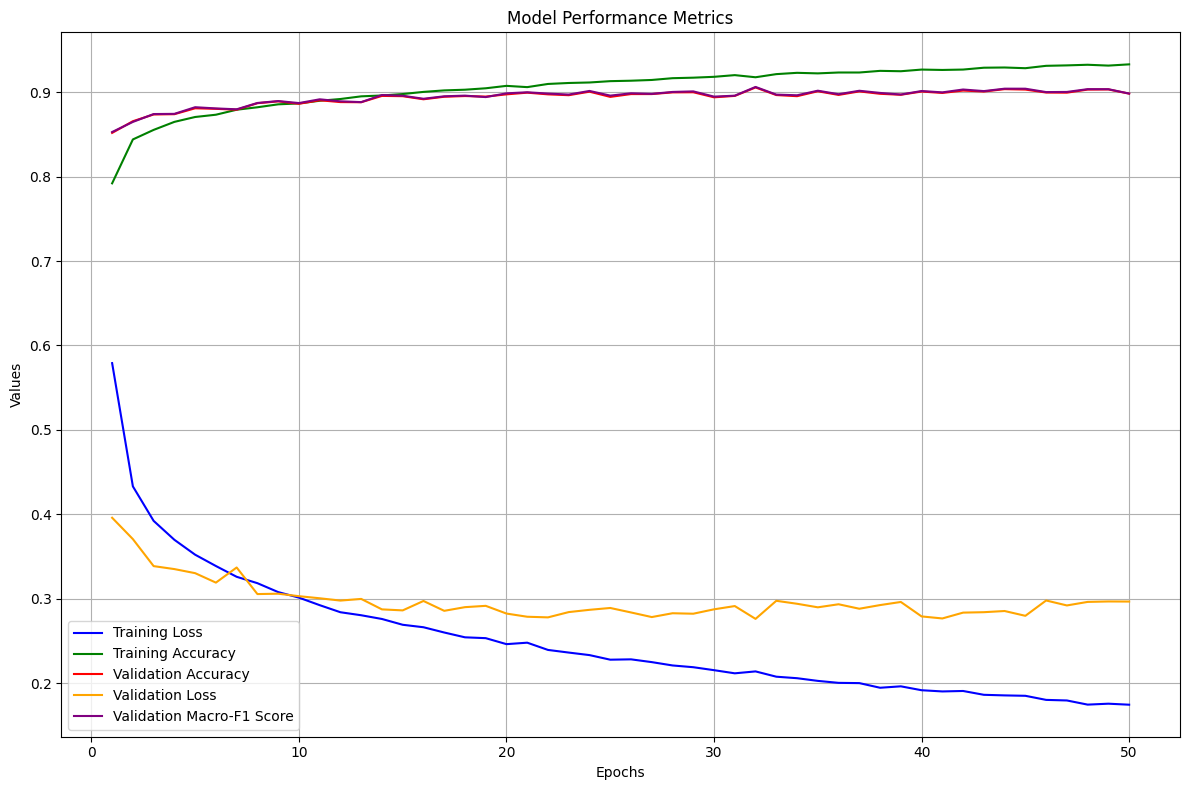

Val Loss: 0.2965, Val Accuracy: 0.8983, Val Macro F1: 0.8984
Confusion Matrix:
[[521   2  12   9   1   0  51   0   1   0]
 [  2 593   0  12   1   0   0   0   0   0]
 [ 13   0 533   3  37   0  25   0   0   0]
 [ 16   0   2 543  16   0   8   0   2   0]
 [  1   0  50  25 535   0  13   0   3   0]
 [  0   0   0   0   0 608   0   7   0   6]
 [ 85   3  62  11  53   0 400   0   5   0]
 [  0   0   0   0   0  12   0 526   0  12]
 [  0   0   3   1   7   0   6   2 571   0]
 [  0   0   0   0   0   8   0  22   0 560]]
Trying configuration: {'learning_rate': 0.001, 'num_epochs': 50, 'batch_size': 128, 'hidden_layers': [{'size': 1024, 'bn': True, 'dropout': 0.3, 'relu': True}, {'size': 512, 'bn': True, 'dropout': 0.5, 'relu': True}]}


100%|██████████| 421/421 [00:39<00:00, 10.71it/s]


Epoch 1/50, Train Loss: 0.5256, Train Accuracy: 0.8121, Val Loss: 0.3668, Val Accuracy: 0.8697, Val Macro F1: 0.8697


100%|██████████| 421/421 [00:37<00:00, 11.28it/s]


Epoch 2/50, Train Loss: 0.3873, Train Accuracy: 0.8588, Val Loss: 0.3844, Val Accuracy: 0.8632, Val Macro F1: 0.8599


100%|██████████| 421/421 [00:39<00:00, 10.62it/s]


Epoch 3/50, Train Loss: 0.3470, Train Accuracy: 0.8724, Val Loss: 0.3225, Val Accuracy: 0.8808, Val Macro F1: 0.8836


100%|██████████| 421/421 [00:37<00:00, 11.15it/s]


Epoch 4/50, Train Loss: 0.3265, Train Accuracy: 0.8784, Val Loss: 0.3178, Val Accuracy: 0.8815, Val Macro F1: 0.8809


100%|██████████| 421/421 [00:39<00:00, 10.61it/s]


Epoch 5/50, Train Loss: 0.3062, Train Accuracy: 0.8873, Val Loss: 0.3177, Val Accuracy: 0.8793, Val Macro F1: 0.8790


100%|██████████| 421/421 [00:37<00:00, 11.10it/s]


Epoch 6/50, Train Loss: 0.2900, Train Accuracy: 0.8912, Val Loss: 0.2988, Val Accuracy: 0.8902, Val Macro F1: 0.8897


100%|██████████| 421/421 [00:38<00:00, 11.06it/s]


Epoch 7/50, Train Loss: 0.2799, Train Accuracy: 0.8955, Val Loss: 0.3011, Val Accuracy: 0.8860, Val Macro F1: 0.8871


100%|██████████| 421/421 [00:39<00:00, 10.63it/s]


Epoch 8/50, Train Loss: 0.2700, Train Accuracy: 0.8988, Val Loss: 0.3064, Val Accuracy: 0.8910, Val Macro F1: 0.8914


100%|██████████| 421/421 [00:38<00:00, 11.03it/s]


Epoch 9/50, Train Loss: 0.2592, Train Accuracy: 0.9029, Val Loss: 0.2997, Val Accuracy: 0.8888, Val Macro F1: 0.8909


100%|██████████| 421/421 [00:39<00:00, 10.64it/s]


Epoch 10/50, Train Loss: 0.2490, Train Accuracy: 0.9064, Val Loss: 0.2972, Val Accuracy: 0.8935, Val Macro F1: 0.8943


100%|██████████| 421/421 [00:37<00:00, 11.23it/s]


Epoch 11/50, Train Loss: 0.2440, Train Accuracy: 0.9079, Val Loss: 0.2944, Val Accuracy: 0.8925, Val Macro F1: 0.8920


100%|██████████| 421/421 [00:39<00:00, 10.63it/s]


Epoch 12/50, Train Loss: 0.2327, Train Accuracy: 0.9131, Val Loss: 0.2888, Val Accuracy: 0.8937, Val Macro F1: 0.8939


100%|██████████| 421/421 [00:37<00:00, 11.09it/s]


Epoch 13/50, Train Loss: 0.2220, Train Accuracy: 0.9174, Val Loss: 0.2921, Val Accuracy: 0.8953, Val Macro F1: 0.8973


100%|██████████| 421/421 [00:39<00:00, 10.70it/s]


Epoch 14/50, Train Loss: 0.2153, Train Accuracy: 0.9189, Val Loss: 0.3038, Val Accuracy: 0.8923, Val Macro F1: 0.8922


100%|██████████| 421/421 [00:38<00:00, 10.80it/s]


Epoch 15/50, Train Loss: 0.2087, Train Accuracy: 0.9201, Val Loss: 0.2903, Val Accuracy: 0.8983, Val Macro F1: 0.8987


100%|██████████| 421/421 [00:36<00:00, 11.54it/s]


Epoch 16/50, Train Loss: 0.2034, Train Accuracy: 0.9232, Val Loss: 0.3049, Val Accuracy: 0.8893, Val Macro F1: 0.8906


100%|██████████| 421/421 [00:39<00:00, 10.75it/s]


Epoch 17/50, Train Loss: 0.1961, Train Accuracy: 0.9251, Val Loss: 0.2979, Val Accuracy: 0.8962, Val Macro F1: 0.8979


100%|██████████| 421/421 [00:36<00:00, 11.41it/s]


Epoch 18/50, Train Loss: 0.1904, Train Accuracy: 0.9278, Val Loss: 0.2906, Val Accuracy: 0.8978, Val Macro F1: 0.8983


100%|██████████| 421/421 [00:38<00:00, 10.89it/s]


Epoch 19/50, Train Loss: 0.1835, Train Accuracy: 0.9312, Val Loss: 0.3134, Val Accuracy: 0.8890, Val Macro F1: 0.8862


100%|██████████| 421/421 [00:37<00:00, 11.09it/s]


Epoch 20/50, Train Loss: 0.1757, Train Accuracy: 0.9331, Val Loss: 0.2951, Val Accuracy: 0.9018, Val Macro F1: 0.9029


100%|██████████| 421/421 [00:39<00:00, 10.58it/s]


Epoch 21/50, Train Loss: 0.1695, Train Accuracy: 0.9351, Val Loss: 0.3013, Val Accuracy: 0.8997, Val Macro F1: 0.9006


100%|██████████| 421/421 [00:39<00:00, 10.68it/s]


Epoch 22/50, Train Loss: 0.1639, Train Accuracy: 0.9367, Val Loss: 0.3155, Val Accuracy: 0.8945, Val Macro F1: 0.8950


100%|██████████| 421/421 [00:37<00:00, 11.21it/s]


Epoch 23/50, Train Loss: 0.1625, Train Accuracy: 0.9376, Val Loss: 0.3211, Val Accuracy: 0.8963, Val Macro F1: 0.8964


100%|██████████| 421/421 [00:40<00:00, 10.41it/s]


Epoch 24/50, Train Loss: 0.1583, Train Accuracy: 0.9394, Val Loss: 0.3289, Val Accuracy: 0.8857, Val Macro F1: 0.8872


100%|██████████| 421/421 [00:37<00:00, 11.11it/s]


Epoch 25/50, Train Loss: 0.1530, Train Accuracy: 0.9408, Val Loss: 0.3108, Val Accuracy: 0.8960, Val Macro F1: 0.8969


100%|██████████| 421/421 [00:39<00:00, 10.64it/s]


Epoch 26/50, Train Loss: 0.1479, Train Accuracy: 0.9429, Val Loss: 0.3324, Val Accuracy: 0.8918, Val Macro F1: 0.8932


100%|██████████| 421/421 [00:37<00:00, 11.24it/s]


Epoch 27/50, Train Loss: 0.1447, Train Accuracy: 0.9453, Val Loss: 0.3095, Val Accuracy: 0.8998, Val Macro F1: 0.9015


100%|██████████| 421/421 [00:39<00:00, 10.54it/s]


Epoch 28/50, Train Loss: 0.1373, Train Accuracy: 0.9482, Val Loss: 0.3036, Val Accuracy: 0.9043, Val Macro F1: 0.9051


100%|██████████| 421/421 [00:38<00:00, 10.92it/s]


Epoch 29/50, Train Loss: 0.1367, Train Accuracy: 0.9482, Val Loss: 0.3135, Val Accuracy: 0.8988, Val Macro F1: 0.8996


100%|██████████| 421/421 [00:39<00:00, 10.60it/s]


Epoch 30/50, Train Loss: 0.1316, Train Accuracy: 0.9500, Val Loss: 0.3338, Val Accuracy: 0.8972, Val Macro F1: 0.8982


100%|██████████| 421/421 [00:39<00:00, 10.67it/s]


Epoch 31/50, Train Loss: 0.1293, Train Accuracy: 0.9517, Val Loss: 0.3183, Val Accuracy: 0.8977, Val Macro F1: 0.8979


100%|██████████| 421/421 [00:37<00:00, 11.32it/s]


Epoch 32/50, Train Loss: 0.1258, Train Accuracy: 0.9528, Val Loss: 0.3304, Val Accuracy: 0.8965, Val Macro F1: 0.8968


100%|██████████| 421/421 [00:40<00:00, 10.42it/s]


Epoch 33/50, Train Loss: 0.1195, Train Accuracy: 0.9548, Val Loss: 0.3122, Val Accuracy: 0.9000, Val Macro F1: 0.9012


100%|██████████| 421/421 [00:37<00:00, 11.36it/s]


Epoch 34/50, Train Loss: 0.1200, Train Accuracy: 0.9539, Val Loss: 0.3358, Val Accuracy: 0.9018, Val Macro F1: 0.9024


100%|██████████| 421/421 [00:41<00:00, 10.15it/s]


Epoch 35/50, Train Loss: 0.1157, Train Accuracy: 0.9554, Val Loss: 0.3163, Val Accuracy: 0.9017, Val Macro F1: 0.9025


100%|██████████| 421/421 [00:36<00:00, 11.45it/s]


Epoch 36/50, Train Loss: 0.1120, Train Accuracy: 0.9577, Val Loss: 0.3402, Val Accuracy: 0.9032, Val Macro F1: 0.9037


100%|██████████| 421/421 [00:39<00:00, 10.71it/s]


Epoch 37/50, Train Loss: 0.1111, Train Accuracy: 0.9577, Val Loss: 0.3366, Val Accuracy: 0.9043, Val Macro F1: 0.9050


100%|██████████| 421/421 [00:38<00:00, 11.04it/s]


Epoch 38/50, Train Loss: 0.1086, Train Accuracy: 0.9588, Val Loss: 0.3524, Val Accuracy: 0.8985, Val Macro F1: 0.9002


100%|██████████| 421/421 [00:38<00:00, 11.07it/s]


Epoch 39/50, Train Loss: 0.1085, Train Accuracy: 0.9576, Val Loss: 0.3623, Val Accuracy: 0.8958, Val Macro F1: 0.8953


100%|██████████| 421/421 [00:40<00:00, 10.31it/s]


Epoch 40/50, Train Loss: 0.1079, Train Accuracy: 0.9594, Val Loss: 0.3449, Val Accuracy: 0.9023, Val Macro F1: 0.9029


100%|██████████| 421/421 [00:37<00:00, 11.26it/s]


Epoch 41/50, Train Loss: 0.1024, Train Accuracy: 0.9615, Val Loss: 0.3545, Val Accuracy: 0.8958, Val Macro F1: 0.8972


100%|██████████| 421/421 [00:40<00:00, 10.46it/s]


Epoch 42/50, Train Loss: 0.1006, Train Accuracy: 0.9613, Val Loss: 0.3488, Val Accuracy: 0.9005, Val Macro F1: 0.9015


100%|██████████| 421/421 [00:37<00:00, 11.25it/s]


Epoch 43/50, Train Loss: 0.0984, Train Accuracy: 0.9626, Val Loss: 0.3758, Val Accuracy: 0.8933, Val Macro F1: 0.8961


100%|██████████| 421/421 [00:39<00:00, 10.66it/s]


Epoch 44/50, Train Loss: 0.0974, Train Accuracy: 0.9631, Val Loss: 0.3573, Val Accuracy: 0.8983, Val Macro F1: 0.8985


100%|██████████| 421/421 [00:37<00:00, 11.09it/s]


Epoch 45/50, Train Loss: 0.0927, Train Accuracy: 0.9636, Val Loss: 0.3573, Val Accuracy: 0.8953, Val Macro F1: 0.8971


100%|██████████| 421/421 [00:40<00:00, 10.45it/s]


Epoch 46/50, Train Loss: 0.0940, Train Accuracy: 0.9643, Val Loss: 0.3711, Val Accuracy: 0.8988, Val Macro F1: 0.8992


100%|██████████| 421/421 [00:39<00:00, 10.53it/s]


Epoch 47/50, Train Loss: 0.0896, Train Accuracy: 0.9652, Val Loss: 0.3831, Val Accuracy: 0.9003, Val Macro F1: 0.9025


100%|██████████| 421/421 [00:37<00:00, 11.29it/s]


Epoch 48/50, Train Loss: 0.0900, Train Accuracy: 0.9654, Val Loss: 0.3625, Val Accuracy: 0.8998, Val Macro F1: 0.9012


100%|██████████| 421/421 [00:39<00:00, 10.54it/s]


Epoch 49/50, Train Loss: 0.0867, Train Accuracy: 0.9664, Val Loss: 0.3999, Val Accuracy: 0.8995, Val Macro F1: 0.8998


100%|██████████| 421/421 [00:37<00:00, 11.15it/s]


Epoch 50/50, Train Loss: 0.0852, Train Accuracy: 0.9674, Val Loss: 0.4086, Val Accuracy: 0.8957, Val Macro F1: 0.8967
For configuration: {'learning_rate': 0.001, 'num_epochs': 50, 'batch_size': 128, 'hidden_layers': [{'size': 1024, 'bn': True, 'dropout': 0.3, 'relu': True}, {'size': 512, 'bn': True, 'dropout': 0.5, 'relu': True}]}


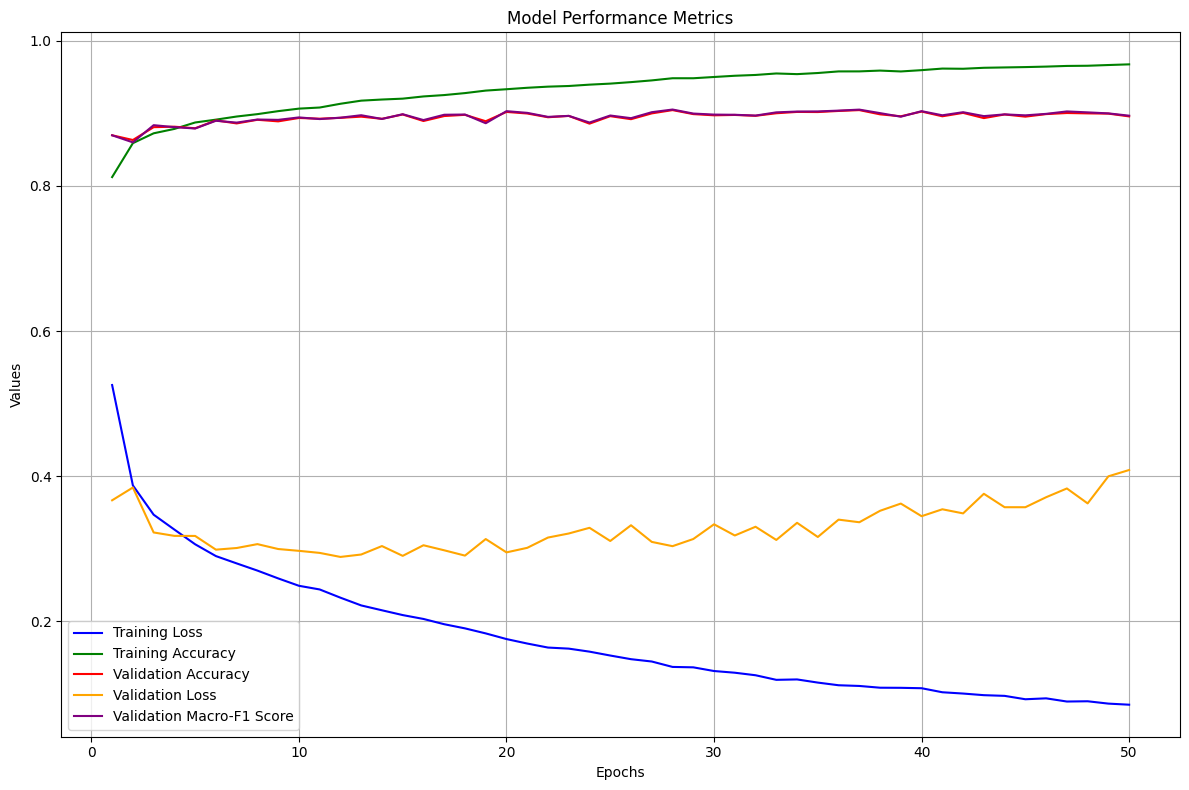

Val Loss: 0.4086, Val Accuracy: 0.8957, Val Macro F1: 0.8967
Confusion Matrix:
[[537   1   5   6   5   0  41   0   2   0]
 [  1 596   0   6   4   0   1   0   0   0]
 [ 25   0 477   4  82   0  23   0   0   0]
 [ 21   1   4 512  39   0   8   1   1   0]
 [  1   0  16   9 578   0  20   0   3   0]
 [  0   0   0   0   0 589   0  20   2  10]
 [ 81   0  34   9  65   0 425   0   5   0]
 [  0   0   0   0   0   3   0 540   0   7]
 [  1   0   2   0   8   1   6   4 568   0]
 [  0   0   0   0   0   7   0  30   1 552]]
Plot:


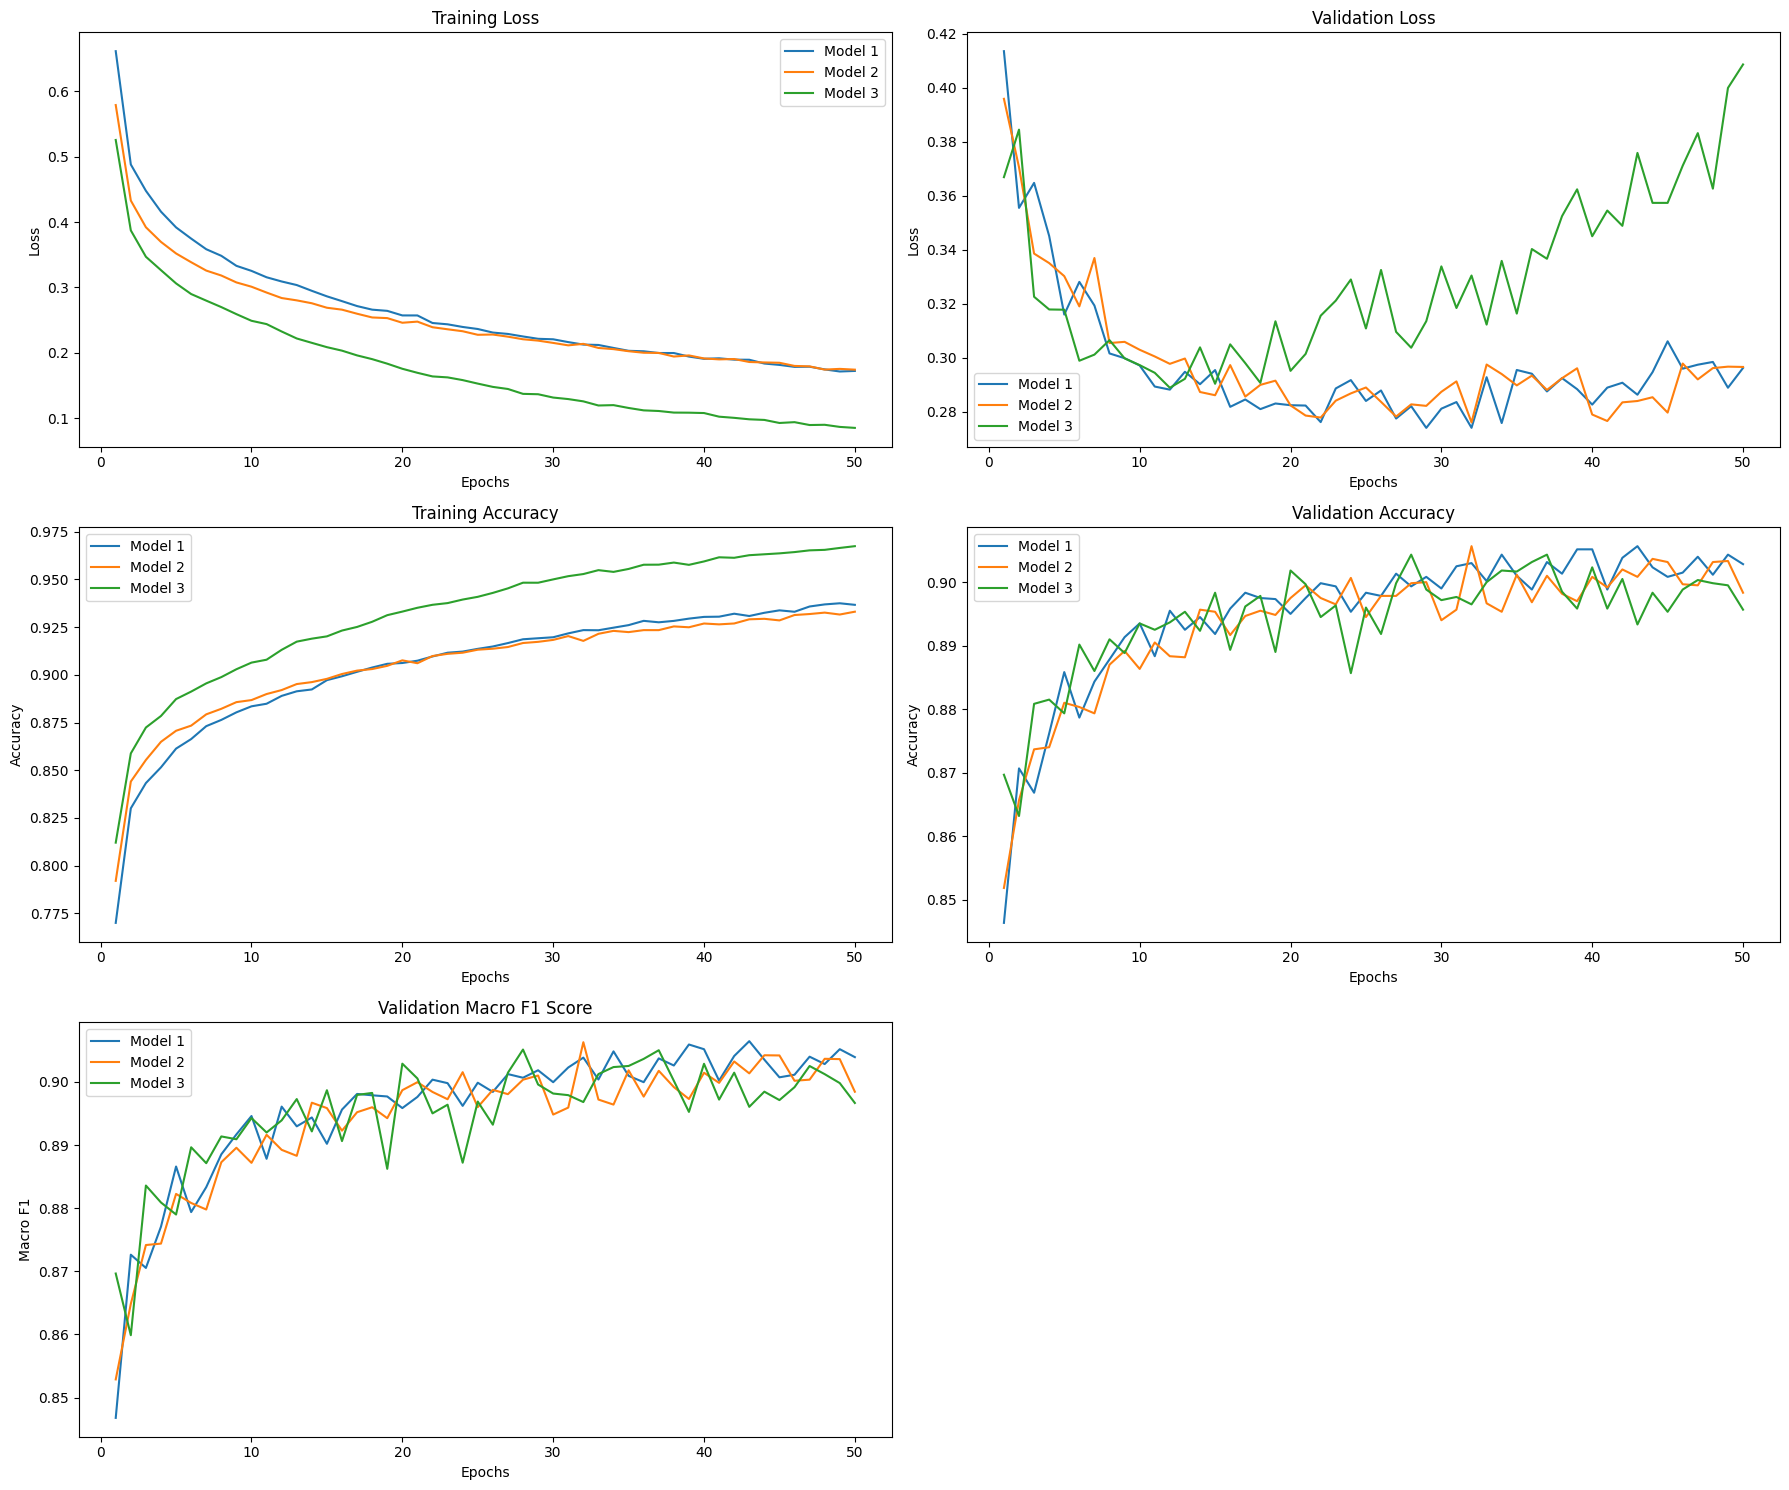

In [26]:
configs = [config_model_1, config_model_2, config_model_3]
best_model, best_config, best_f1 = train_and_evaluate_models(configs,X_train, y_train_one_hot, X_val, y_val_one_hot,y_val_labels)

In [27]:
print("Best Config:")
print(best_config)

Best Config:
{'learning_rate': 0.001, 'num_epochs': 50, 'batch_size': 32, 'hidden_layers': [{'size': 512, 'bn': True, 'dropout': 0.3, 'relu': True}, {'size': 256, 'bn': False, 'dropout': 0.4, 'relu': True}, {'size': 128, 'bn': True, 'dropout': 0.5, 'relu': True}]}


In [28]:
print("Best Val Macro F1:")
print(best_f1)

Best Val Macro F1:
0.903930255275041


**With Four Different Learning Rates**

In [29]:
config_model_1 = best_config.copy()
config_model_1['learning_rate'] = 0.005

In [30]:
config_model_2 = best_config.copy()
config_model_2['learning_rate'] = 0.0001

In [31]:
config_model_3 = best_config.copy()
config_model_3['learning_rate'] = 0.0005

In [32]:
config_model_4 = best_config.copy()
config_model_4['learning_rate'] = 0.00001

Trying configuration: {'learning_rate': 0.005, 'num_epochs': 50, 'batch_size': 32, 'hidden_layers': [{'size': 512, 'bn': True, 'dropout': 0.3, 'relu': True}, {'size': 256, 'bn': False, 'dropout': 0.4, 'relu': True}, {'size': 128, 'bn': True, 'dropout': 0.5, 'relu': True}]}


100%|██████████| 1687/1687 [00:45<00:00, 37.40it/s]


Epoch 1/50, Train Loss: 0.6428, Train Accuracy: 0.7762, Val Loss: 0.4270, Val Accuracy: 0.8410, Val Macro F1: 0.8406


100%|██████████| 1687/1687 [00:48<00:00, 34.79it/s]


Epoch 2/50, Train Loss: 0.4943, Train Accuracy: 0.8278, Val Loss: 0.3832, Val Accuracy: 0.8557, Val Macro F1: 0.8558


100%|██████████| 1687/1687 [00:48<00:00, 35.03it/s]


Epoch 3/50, Train Loss: 0.4586, Train Accuracy: 0.8388, Val Loss: 0.3612, Val Accuracy: 0.8623, Val Macro F1: 0.8649


100%|██████████| 1687/1687 [00:46<00:00, 36.13it/s]


Epoch 4/50, Train Loss: 0.4202, Train Accuracy: 0.8508, Val Loss: 0.3678, Val Accuracy: 0.8622, Val Macro F1: 0.8611


100%|██████████| 1687/1687 [00:50<00:00, 33.47it/s]


Epoch 5/50, Train Loss: 0.4072, Train Accuracy: 0.8569, Val Loss: 0.3226, Val Accuracy: 0.8822, Val Macro F1: 0.8824


100%|██████████| 1687/1687 [00:51<00:00, 32.54it/s]


Epoch 6/50, Train Loss: 0.3886, Train Accuracy: 0.8639, Val Loss: 0.3312, Val Accuracy: 0.8798, Val Macro F1: 0.8805


100%|██████████| 1687/1687 [00:48<00:00, 34.95it/s]


Epoch 7/50, Train Loss: 0.3792, Train Accuracy: 0.8647, Val Loss: 0.3118, Val Accuracy: 0.8923, Val Macro F1: 0.8925


100%|██████████| 1687/1687 [00:53<00:00, 31.76it/s]


Epoch 8/50, Train Loss: 0.3628, Train Accuracy: 0.8730, Val Loss: 0.3164, Val Accuracy: 0.8845, Val Macro F1: 0.8845


100%|██████████| 1687/1687 [00:53<00:00, 31.50it/s]


Epoch 9/50, Train Loss: 0.3505, Train Accuracy: 0.8758, Val Loss: 0.3138, Val Accuracy: 0.8862, Val Macro F1: 0.8871


100%|██████████| 1687/1687 [00:51<00:00, 32.85it/s]


Epoch 10/50, Train Loss: 0.3427, Train Accuracy: 0.8775, Val Loss: 0.3024, Val Accuracy: 0.8877, Val Macro F1: 0.8881


100%|██████████| 1687/1687 [00:53<00:00, 31.76it/s]


Epoch 11/50, Train Loss: 0.3296, Train Accuracy: 0.8812, Val Loss: 0.3188, Val Accuracy: 0.8820, Val Macro F1: 0.8807


100%|██████████| 1687/1687 [00:53<00:00, 31.45it/s]


Epoch 12/50, Train Loss: 0.3290, Train Accuracy: 0.8818, Val Loss: 0.3098, Val Accuracy: 0.8842, Val Macro F1: 0.8848


100%|██████████| 1687/1687 [00:55<00:00, 30.41it/s]


Epoch 13/50, Train Loss: 0.3177, Train Accuracy: 0.8857, Val Loss: 0.3041, Val Accuracy: 0.8883, Val Macro F1: 0.8876


100%|██████████| 1687/1687 [00:54<00:00, 31.13it/s]


Epoch 14/50, Train Loss: 0.3124, Train Accuracy: 0.8883, Val Loss: 0.2930, Val Accuracy: 0.8953, Val Macro F1: 0.8957


100%|██████████| 1687/1687 [00:53<00:00, 31.67it/s]


Epoch 15/50, Train Loss: 0.3049, Train Accuracy: 0.8904, Val Loss: 0.2954, Val Accuracy: 0.8938, Val Macro F1: 0.8945


100%|██████████| 1687/1687 [00:54<00:00, 30.80it/s]


Epoch 16/50, Train Loss: 0.3005, Train Accuracy: 0.8927, Val Loss: 0.3010, Val Accuracy: 0.8932, Val Macro F1: 0.8951


100%|██████████| 1687/1687 [00:56<00:00, 29.98it/s]


Epoch 17/50, Train Loss: 0.2938, Train Accuracy: 0.8934, Val Loss: 0.2911, Val Accuracy: 0.8970, Val Macro F1: 0.8976


100%|██████████| 1687/1687 [00:55<00:00, 30.47it/s]


Epoch 18/50, Train Loss: 0.2890, Train Accuracy: 0.8960, Val Loss: 0.3073, Val Accuracy: 0.8895, Val Macro F1: 0.8920


100%|██████████| 1687/1687 [00:53<00:00, 31.40it/s]


Epoch 19/50, Train Loss: 0.2905, Train Accuracy: 0.8957, Val Loss: 0.2887, Val Accuracy: 0.8977, Val Macro F1: 0.8979


100%|██████████| 1687/1687 [00:56<00:00, 29.68it/s]


Epoch 20/50, Train Loss: 0.2780, Train Accuracy: 0.8996, Val Loss: 0.2848, Val Accuracy: 0.8998, Val Macro F1: 0.9010


100%|██████████| 1687/1687 [00:56<00:00, 29.64it/s]


Epoch 21/50, Train Loss: 0.2770, Train Accuracy: 0.9013, Val Loss: 0.2933, Val Accuracy: 0.9010, Val Macro F1: 0.9023


100%|██████████| 1687/1687 [00:57<00:00, 29.39it/s]


Epoch 22/50, Train Loss: 0.2706, Train Accuracy: 0.9024, Val Loss: 0.2948, Val Accuracy: 0.8958, Val Macro F1: 0.8958


100%|██████████| 1687/1687 [00:56<00:00, 29.77it/s]


Epoch 23/50, Train Loss: 0.2641, Train Accuracy: 0.9046, Val Loss: 0.2940, Val Accuracy: 0.8977, Val Macro F1: 0.8990


100%|██████████| 1687/1687 [00:58<00:00, 29.02it/s]


Epoch 24/50, Train Loss: 0.2643, Train Accuracy: 0.9039, Val Loss: 0.2824, Val Accuracy: 0.9025, Val Macro F1: 0.9028


100%|██████████| 1687/1687 [00:59<00:00, 28.55it/s]


Epoch 25/50, Train Loss: 0.2593, Train Accuracy: 0.9066, Val Loss: 0.2909, Val Accuracy: 0.9022, Val Macro F1: 0.9022


100%|██████████| 1687/1687 [00:57<00:00, 29.32it/s]


Epoch 26/50, Train Loss: 0.2558, Train Accuracy: 0.9082, Val Loss: 0.3215, Val Accuracy: 0.8880, Val Macro F1: 0.8915


100%|██████████| 1687/1687 [00:58<00:00, 28.96it/s]


Epoch 27/50, Train Loss: 0.2522, Train Accuracy: 0.9088, Val Loss: 0.2844, Val Accuracy: 0.8990, Val Macro F1: 0.8991


100%|██████████| 1687/1687 [00:56<00:00, 29.86it/s]


Epoch 28/50, Train Loss: 0.2511, Train Accuracy: 0.9100, Val Loss: 0.2871, Val Accuracy: 0.9025, Val Macro F1: 0.9030


100%|██████████| 1687/1687 [00:58<00:00, 29.03it/s]


Epoch 29/50, Train Loss: 0.2488, Train Accuracy: 0.9113, Val Loss: 0.2862, Val Accuracy: 0.8990, Val Macro F1: 0.8992


100%|██████████| 1687/1687 [00:58<00:00, 28.66it/s]


Epoch 30/50, Train Loss: 0.2431, Train Accuracy: 0.9128, Val Loss: 0.2963, Val Accuracy: 0.8973, Val Macro F1: 0.8976


100%|██████████| 1687/1687 [00:56<00:00, 29.65it/s]


Epoch 31/50, Train Loss: 0.2415, Train Accuracy: 0.9133, Val Loss: 0.2937, Val Accuracy: 0.8968, Val Macro F1: 0.8975


100%|██████████| 1687/1687 [01:01<00:00, 27.65it/s]


Epoch 32/50, Train Loss: 0.2367, Train Accuracy: 0.9148, Val Loss: 0.2999, Val Accuracy: 0.8957, Val Macro F1: 0.8957


100%|██████████| 1687/1687 [00:57<00:00, 29.26it/s]


Epoch 33/50, Train Loss: 0.2348, Train Accuracy: 0.9144, Val Loss: 0.3049, Val Accuracy: 0.8938, Val Macro F1: 0.8938


100%|██████████| 1687/1687 [00:59<00:00, 28.15it/s]


Epoch 34/50, Train Loss: 0.2315, Train Accuracy: 0.9166, Val Loss: 0.2867, Val Accuracy: 0.8990, Val Macro F1: 0.9003


100%|██████████| 1687/1687 [00:57<00:00, 29.29it/s]


Epoch 35/50, Train Loss: 0.2338, Train Accuracy: 0.9159, Val Loss: 0.2957, Val Accuracy: 0.8967, Val Macro F1: 0.8965


100%|██████████| 1687/1687 [00:57<00:00, 29.16it/s]


Epoch 36/50, Train Loss: 0.2300, Train Accuracy: 0.9160, Val Loss: 0.2944, Val Accuracy: 0.9035, Val Macro F1: 0.9040


100%|██████████| 1687/1687 [00:59<00:00, 28.17it/s]


Epoch 37/50, Train Loss: 0.2257, Train Accuracy: 0.9196, Val Loss: 0.2902, Val Accuracy: 0.9030, Val Macro F1: 0.9042


100%|██████████| 1687/1687 [00:56<00:00, 29.84it/s]


Epoch 38/50, Train Loss: 0.2221, Train Accuracy: 0.9194, Val Loss: 0.2898, Val Accuracy: 0.9000, Val Macro F1: 0.9001


100%|██████████| 1687/1687 [01:00<00:00, 27.85it/s]


Epoch 39/50, Train Loss: 0.2213, Train Accuracy: 0.9205, Val Loss: 0.2919, Val Accuracy: 0.9028, Val Macro F1: 0.9037


100%|██████████| 1687/1687 [00:58<00:00, 29.06it/s]


Epoch 40/50, Train Loss: 0.2155, Train Accuracy: 0.9221, Val Loss: 0.2884, Val Accuracy: 0.9023, Val Macro F1: 0.9035


100%|██████████| 1687/1687 [01:01<00:00, 27.64it/s]


Epoch 41/50, Train Loss: 0.2119, Train Accuracy: 0.9227, Val Loss: 0.2925, Val Accuracy: 0.8978, Val Macro F1: 0.8984


100%|██████████| 1687/1687 [00:58<00:00, 28.82it/s]


Epoch 42/50, Train Loss: 0.2138, Train Accuracy: 0.9237, Val Loss: 0.2847, Val Accuracy: 0.9015, Val Macro F1: 0.9022


100%|██████████| 1687/1687 [00:58<00:00, 28.91it/s]


Epoch 43/50, Train Loss: 0.2146, Train Accuracy: 0.9238, Val Loss: 0.2872, Val Accuracy: 0.8997, Val Macro F1: 0.9006


100%|██████████| 1687/1687 [01:01<00:00, 27.56it/s]


Epoch 44/50, Train Loss: 0.2087, Train Accuracy: 0.9249, Val Loss: 0.3036, Val Accuracy: 0.9023, Val Macro F1: 0.9034


100%|██████████| 1687/1687 [00:56<00:00, 29.70it/s]


Epoch 45/50, Train Loss: 0.2073, Train Accuracy: 0.9254, Val Loss: 0.2998, Val Accuracy: 0.9005, Val Macro F1: 0.9003


100%|██████████| 1687/1687 [01:00<00:00, 27.94it/s]


Epoch 46/50, Train Loss: 0.2040, Train Accuracy: 0.9258, Val Loss: 0.2950, Val Accuracy: 0.9023, Val Macro F1: 0.9036


100%|██████████| 1687/1687 [00:57<00:00, 29.43it/s]


Epoch 47/50, Train Loss: 0.2032, Train Accuracy: 0.9271, Val Loss: 0.3030, Val Accuracy: 0.9003, Val Macro F1: 0.9010


100%|██████████| 1687/1687 [01:01<00:00, 27.22it/s]


Epoch 48/50, Train Loss: 0.2053, Train Accuracy: 0.9271, Val Loss: 0.3050, Val Accuracy: 0.9045, Val Macro F1: 0.9056


100%|██████████| 1687/1687 [00:59<00:00, 28.45it/s]


Epoch 49/50, Train Loss: 0.1996, Train Accuracy: 0.9289, Val Loss: 0.3135, Val Accuracy: 0.9007, Val Macro F1: 0.9012


100%|██████████| 1687/1687 [01:02<00:00, 27.17it/s]


Epoch 50/50, Train Loss: 0.1981, Train Accuracy: 0.9283, Val Loss: 0.3018, Val Accuracy: 0.9038, Val Macro F1: 0.9044
For configuration: {'learning_rate': 0.005, 'num_epochs': 50, 'batch_size': 32, 'hidden_layers': [{'size': 512, 'bn': True, 'dropout': 0.3, 'relu': True}, {'size': 256, 'bn': False, 'dropout': 0.4, 'relu': True}, {'size': 128, 'bn': True, 'dropout': 0.5, 'relu': True}]}


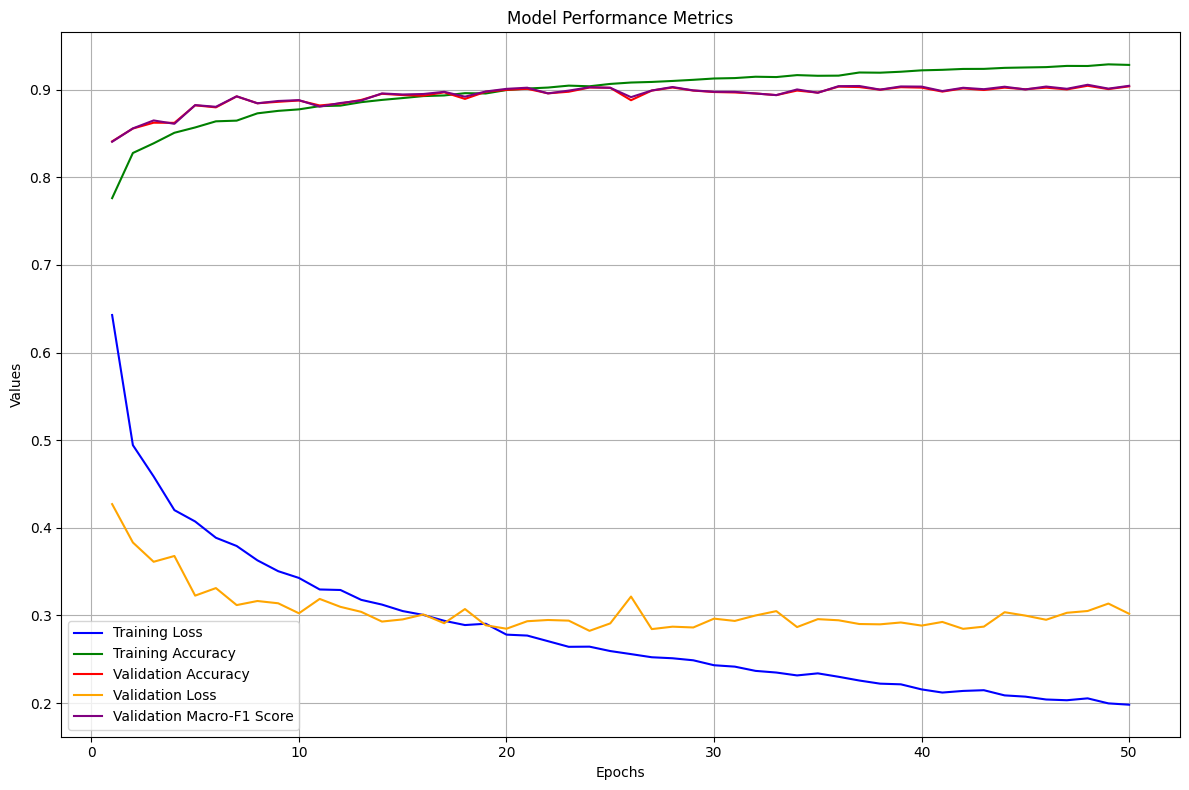

Val Loss: 0.3018, Val Accuracy: 0.9038, Val Macro F1: 0.9044
Confusion Matrix:
[[509   2   8  16   2   0  57   0   3   0]
 [  1 601   0   6   0   0   0   0   0   0]
 [ 12   1 524   4  41   0  29   0   0   0]
 [  9   4   2 544  15   0  11   0   1   1]
 [  1   0  38  28 531   0  26   0   3   0]
 [  0   0   0   0   0 599   0  12   1   9]
 [ 62   1  45  19  30   1 455   0   6   0]
 [  0   0   0   0   0   6   0 525   0  19]
 [  0   0   3   3   3   1   7   2 571   0]
 [  0   0   0   0   0   6   0  20   0 564]]
Trying configuration: {'learning_rate': 0.0001, 'num_epochs': 50, 'batch_size': 32, 'hidden_layers': [{'size': 512, 'bn': True, 'dropout': 0.3, 'relu': True}, {'size': 256, 'bn': False, 'dropout': 0.4, 'relu': True}, {'size': 128, 'bn': True, 'dropout': 0.5, 'relu': True}]}


100%|██████████| 1687/1687 [00:46<00:00, 36.07it/s]


Epoch 1/50, Train Loss: 1.0584, Train Accuracy: 0.6457, Val Loss: 0.5060, Val Accuracy: 0.8188, Val Macro F1: 0.8207


100%|██████████| 1687/1687 [00:45<00:00, 36.90it/s]


Epoch 2/50, Train Loss: 0.6563, Train Accuracy: 0.7760, Val Loss: 0.4254, Val Accuracy: 0.8478, Val Macro F1: 0.8487


100%|██████████| 1687/1687 [00:50<00:00, 33.72it/s]


Epoch 3/50, Train Loss: 0.5661, Train Accuracy: 0.8076, Val Loss: 0.3919, Val Accuracy: 0.8590, Val Macro F1: 0.8614


100%|██████████| 1687/1687 [00:44<00:00, 37.64it/s]


Epoch 4/50, Train Loss: 0.5128, Train Accuracy: 0.8243, Val Loss: 0.3674, Val Accuracy: 0.8663, Val Macro F1: 0.8669


100%|██████████| 1687/1687 [00:47<00:00, 35.71it/s]


Epoch 5/50, Train Loss: 0.4773, Train Accuracy: 0.8349, Val Loss: 0.3489, Val Accuracy: 0.8742, Val Macro F1: 0.8751


100%|██████████| 1687/1687 [00:49<00:00, 34.36it/s]


Epoch 6/50, Train Loss: 0.4522, Train Accuracy: 0.8438, Val Loss: 0.3421, Val Accuracy: 0.8722, Val Macro F1: 0.8737


100%|██████████| 1687/1687 [00:46<00:00, 36.05it/s]


Epoch 7/50, Train Loss: 0.4335, Train Accuracy: 0.8494, Val Loss: 0.3330, Val Accuracy: 0.8797, Val Macro F1: 0.8794


100%|██████████| 1687/1687 [00:44<00:00, 37.60it/s]


Epoch 8/50, Train Loss: 0.4188, Train Accuracy: 0.8540, Val Loss: 0.3246, Val Accuracy: 0.8790, Val Macro F1: 0.8801


100%|██████████| 1687/1687 [00:49<00:00, 33.89it/s]


Epoch 9/50, Train Loss: 0.3975, Train Accuracy: 0.8613, Val Loss: 0.3175, Val Accuracy: 0.8880, Val Macro F1: 0.8891


100%|██████████| 1687/1687 [00:45<00:00, 36.94it/s]


Epoch 10/50, Train Loss: 0.3892, Train Accuracy: 0.8644, Val Loss: 0.3104, Val Accuracy: 0.8882, Val Macro F1: 0.8890


100%|██████████| 1687/1687 [00:45<00:00, 36.88it/s]


Epoch 11/50, Train Loss: 0.3780, Train Accuracy: 0.8679, Val Loss: 0.3063, Val Accuracy: 0.8852, Val Macro F1: 0.8863


100%|██████████| 1687/1687 [00:50<00:00, 33.41it/s]


Epoch 12/50, Train Loss: 0.3665, Train Accuracy: 0.8716, Val Loss: 0.3090, Val Accuracy: 0.8878, Val Macro F1: 0.8891


100%|██████████| 1687/1687 [00:46<00:00, 36.26it/s]


Epoch 13/50, Train Loss: 0.3564, Train Accuracy: 0.8730, Val Loss: 0.3050, Val Accuracy: 0.8873, Val Macro F1: 0.8874


100%|██████████| 1687/1687 [00:46<00:00, 36.54it/s]


Epoch 14/50, Train Loss: 0.3492, Train Accuracy: 0.8764, Val Loss: 0.2970, Val Accuracy: 0.8918, Val Macro F1: 0.8925


100%|██████████| 1687/1687 [00:50<00:00, 33.46it/s]


Epoch 15/50, Train Loss: 0.3399, Train Accuracy: 0.8786, Val Loss: 0.3000, Val Accuracy: 0.8928, Val Macro F1: 0.8942


100%|██████████| 1687/1687 [00:47<00:00, 35.88it/s]


Epoch 16/50, Train Loss: 0.3354, Train Accuracy: 0.8812, Val Loss: 0.2908, Val Accuracy: 0.8950, Val Macro F1: 0.8955


100%|██████████| 1687/1687 [00:46<00:00, 36.25it/s]


Epoch 17/50, Train Loss: 0.3288, Train Accuracy: 0.8816, Val Loss: 0.2948, Val Accuracy: 0.8917, Val Macro F1: 0.8921


100%|██████████| 1687/1687 [00:50<00:00, 33.27it/s]


Epoch 18/50, Train Loss: 0.3252, Train Accuracy: 0.8839, Val Loss: 0.2915, Val Accuracy: 0.8882, Val Macro F1: 0.8889


100%|██████████| 1687/1687 [00:46<00:00, 36.29it/s]


Epoch 19/50, Train Loss: 0.3172, Train Accuracy: 0.8872, Val Loss: 0.2894, Val Accuracy: 0.8918, Val Macro F1: 0.8935


100%|██████████| 1687/1687 [00:51<00:00, 32.60it/s]


Epoch 20/50, Train Loss: 0.3116, Train Accuracy: 0.8886, Val Loss: 0.2898, Val Accuracy: 0.8953, Val Macro F1: 0.8960


100%|██████████| 1687/1687 [00:48<00:00, 34.94it/s]


Epoch 21/50, Train Loss: 0.3026, Train Accuracy: 0.8910, Val Loss: 0.2853, Val Accuracy: 0.8952, Val Macro F1: 0.8963


100%|██████████| 1687/1687 [00:47<00:00, 35.69it/s]


Epoch 22/50, Train Loss: 0.3029, Train Accuracy: 0.8912, Val Loss: 0.2890, Val Accuracy: 0.8963, Val Macro F1: 0.8971


100%|██████████| 1687/1687 [00:51<00:00, 32.54it/s]


Epoch 23/50, Train Loss: 0.2954, Train Accuracy: 0.8950, Val Loss: 0.2861, Val Accuracy: 0.8960, Val Macro F1: 0.8962


100%|██████████| 1687/1687 [00:47<00:00, 35.37it/s]


Epoch 24/50, Train Loss: 0.2895, Train Accuracy: 0.8950, Val Loss: 0.2798, Val Accuracy: 0.8967, Val Macro F1: 0.8971


100%|██████████| 1687/1687 [00:45<00:00, 36.75it/s]


Epoch 25/50, Train Loss: 0.2857, Train Accuracy: 0.8964, Val Loss: 0.2792, Val Accuracy: 0.8957, Val Macro F1: 0.8965


100%|██████████| 1687/1687 [00:51<00:00, 32.92it/s]


Epoch 26/50, Train Loss: 0.2833, Train Accuracy: 0.8973, Val Loss: 0.2789, Val Accuracy: 0.8960, Val Macro F1: 0.8972


100%|██████████| 1687/1687 [00:47<00:00, 35.50it/s]


Epoch 27/50, Train Loss: 0.2785, Train Accuracy: 0.9003, Val Loss: 0.2811, Val Accuracy: 0.8973, Val Macro F1: 0.8980


100%|██████████| 1687/1687 [00:47<00:00, 35.84it/s]


Epoch 28/50, Train Loss: 0.2751, Train Accuracy: 0.9013, Val Loss: 0.2816, Val Accuracy: 0.8950, Val Macro F1: 0.8961


100%|██████████| 1687/1687 [00:52<00:00, 32.26it/s]


Epoch 29/50, Train Loss: 0.2667, Train Accuracy: 0.9043, Val Loss: 0.2800, Val Accuracy: 0.8972, Val Macro F1: 0.8982


100%|██████████| 1687/1687 [00:46<00:00, 35.96it/s]


Epoch 30/50, Train Loss: 0.2629, Train Accuracy: 0.9048, Val Loss: 0.2748, Val Accuracy: 0.8977, Val Macro F1: 0.8989


100%|██████████| 1687/1687 [00:47<00:00, 35.74it/s]


Epoch 31/50, Train Loss: 0.2632, Train Accuracy: 0.9046, Val Loss: 0.2808, Val Accuracy: 0.8962, Val Macro F1: 0.8966


100%|██████████| 1687/1687 [00:51<00:00, 33.03it/s]


Epoch 32/50, Train Loss: 0.2593, Train Accuracy: 0.9065, Val Loss: 0.2728, Val Accuracy: 0.8995, Val Macro F1: 0.9006


100%|██████████| 1687/1687 [00:47<00:00, 35.84it/s]


Epoch 33/50, Train Loss: 0.2539, Train Accuracy: 0.9087, Val Loss: 0.2730, Val Accuracy: 0.8993, Val Macro F1: 0.8998


100%|██████████| 1687/1687 [00:47<00:00, 35.52it/s]


Epoch 34/50, Train Loss: 0.2515, Train Accuracy: 0.9088, Val Loss: 0.2757, Val Accuracy: 0.8993, Val Macro F1: 0.8998


100%|██████████| 1687/1687 [00:52<00:00, 32.38it/s]


Epoch 35/50, Train Loss: 0.2481, Train Accuracy: 0.9103, Val Loss: 0.2752, Val Accuracy: 0.8990, Val Macro F1: 0.8996


100%|██████████| 1687/1687 [00:46<00:00, 36.16it/s]


Epoch 36/50, Train Loss: 0.2442, Train Accuracy: 0.9117, Val Loss: 0.2804, Val Accuracy: 0.8972, Val Macro F1: 0.8984


100%|██████████| 1687/1687 [00:48<00:00, 34.58it/s]


Epoch 37/50, Train Loss: 0.2445, Train Accuracy: 0.9109, Val Loss: 0.2751, Val Accuracy: 0.8978, Val Macro F1: 0.8988


100%|██████████| 1687/1687 [00:49<00:00, 34.15it/s]


Epoch 38/50, Train Loss: 0.2393, Train Accuracy: 0.9131, Val Loss: 0.2773, Val Accuracy: 0.8987, Val Macro F1: 0.8988


100%|██████████| 1687/1687 [00:47<00:00, 35.23it/s]


Epoch 39/50, Train Loss: 0.2346, Train Accuracy: 0.9149, Val Loss: 0.2830, Val Accuracy: 0.8987, Val Macro F1: 0.8999


100%|██████████| 1687/1687 [00:49<00:00, 33.79it/s]


Epoch 40/50, Train Loss: 0.2346, Train Accuracy: 0.9154, Val Loss: 0.2819, Val Accuracy: 0.8987, Val Macro F1: 0.8989


100%|██████████| 1687/1687 [00:48<00:00, 34.85it/s]


Epoch 41/50, Train Loss: 0.2289, Train Accuracy: 0.9173, Val Loss: 0.2762, Val Accuracy: 0.9012, Val Macro F1: 0.9017


100%|██████████| 1687/1687 [00:46<00:00, 36.36it/s]


Epoch 42/50, Train Loss: 0.2270, Train Accuracy: 0.9175, Val Loss: 0.2775, Val Accuracy: 0.9012, Val Macro F1: 0.9020


100%|██████████| 1687/1687 [00:52<00:00, 32.25it/s]


Epoch 43/50, Train Loss: 0.2220, Train Accuracy: 0.9190, Val Loss: 0.2778, Val Accuracy: 0.9002, Val Macro F1: 0.9016


100%|██████████| 1687/1687 [00:45<00:00, 36.76it/s]


Epoch 44/50, Train Loss: 0.2236, Train Accuracy: 0.9189, Val Loss: 0.2800, Val Accuracy: 0.9017, Val Macro F1: 0.9024


100%|██████████| 1687/1687 [00:47<00:00, 35.37it/s]


Epoch 45/50, Train Loss: 0.2204, Train Accuracy: 0.9187, Val Loss: 0.2773, Val Accuracy: 0.9003, Val Macro F1: 0.9012


100%|██████████| 1687/1687 [00:51<00:00, 32.97it/s]


Epoch 46/50, Train Loss: 0.2161, Train Accuracy: 0.9221, Val Loss: 0.2875, Val Accuracy: 0.8993, Val Macro F1: 0.8995


100%|██████████| 1687/1687 [00:46<00:00, 36.23it/s]


Epoch 47/50, Train Loss: 0.2147, Train Accuracy: 0.9228, Val Loss: 0.2824, Val Accuracy: 0.8992, Val Macro F1: 0.8989


100%|██████████| 1687/1687 [00:45<00:00, 37.04it/s]


Epoch 48/50, Train Loss: 0.2141, Train Accuracy: 0.9217, Val Loss: 0.2847, Val Accuracy: 0.8993, Val Macro F1: 0.9005


100%|██████████| 1687/1687 [00:52<00:00, 31.88it/s]


Epoch 49/50, Train Loss: 0.2073, Train Accuracy: 0.9249, Val Loss: 0.2855, Val Accuracy: 0.9005, Val Macro F1: 0.9013


100%|██████████| 1687/1687 [00:46<00:00, 36.26it/s]


Epoch 50/50, Train Loss: 0.2064, Train Accuracy: 0.9251, Val Loss: 0.2762, Val Accuracy: 0.9022, Val Macro F1: 0.9025
For configuration: {'learning_rate': 0.0001, 'num_epochs': 50, 'batch_size': 32, 'hidden_layers': [{'size': 512, 'bn': True, 'dropout': 0.3, 'relu': True}, {'size': 256, 'bn': False, 'dropout': 0.4, 'relu': True}, {'size': 128, 'bn': True, 'dropout': 0.5, 'relu': True}]}


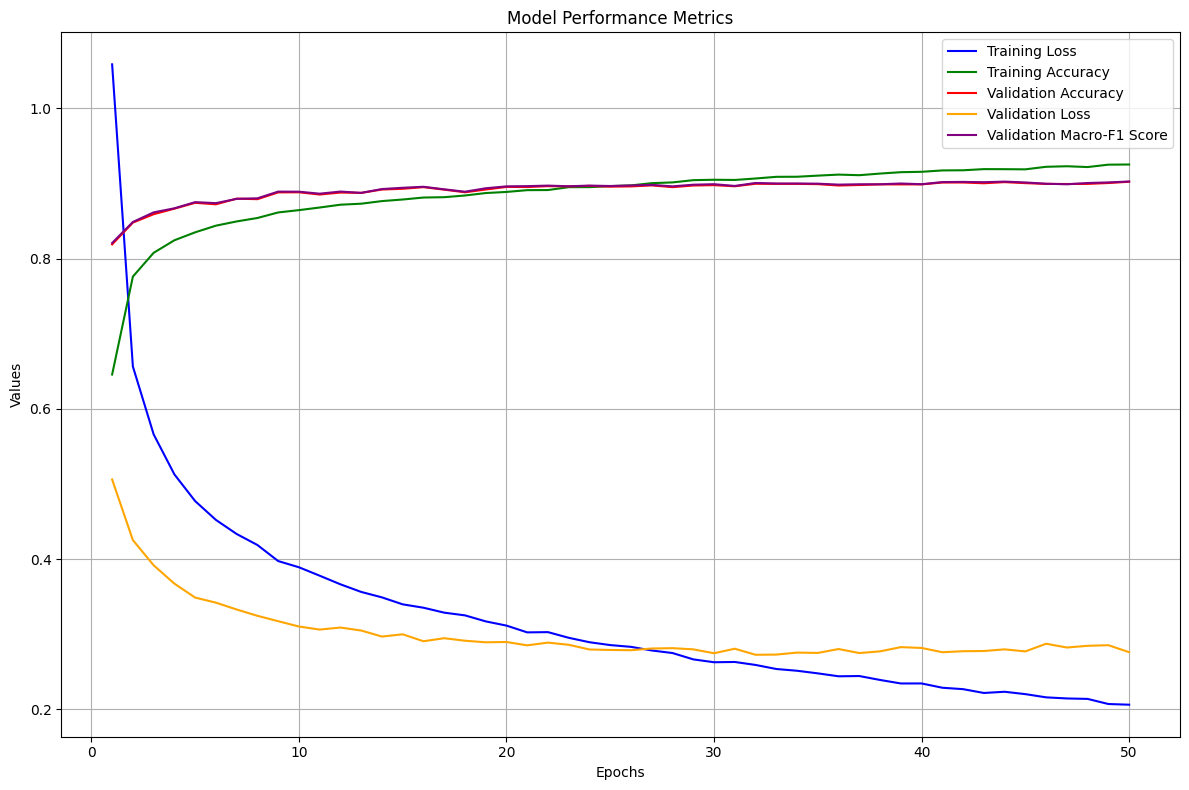

Val Loss: 0.2762, Val Accuracy: 0.9022, Val Macro F1: 0.9025
Confusion Matrix:
[[514   0  15  17   1   0  46   0   4   0]
 [  1 597   0  10   0   0   0   0   0   0]
 [ 11   0 533   4  43   0  20   0   0   0]
 [ 10   0   3 547  20   0   4   0   3   0]
 [  1   0  42  16 525   0  39   0   4   0]
 [  0   0   0   0   0 606   0  11   0   4]
 [ 77   1  55  19  31   1 428   0   7   0]
 [  0   0   0   0   0   9   0 532   0   9]
 [  1   0   3   4   2   2   4   2 572   0]
 [  0   0   0   0   0   6   0  25   0 559]]
Trying configuration: {'learning_rate': 0.0005, 'num_epochs': 50, 'batch_size': 32, 'hidden_layers': [{'size': 512, 'bn': True, 'dropout': 0.3, 'relu': True}, {'size': 256, 'bn': False, 'dropout': 0.4, 'relu': True}, {'size': 128, 'bn': True, 'dropout': 0.5, 'relu': True}]}


100%|██████████| 1687/1687 [00:45<00:00, 36.91it/s]


Epoch 1/50, Train Loss: 0.7359, Train Accuracy: 0.7491, Val Loss: 0.4160, Val Accuracy: 0.8453, Val Macro F1: 0.8450


100%|██████████| 1687/1687 [00:52<00:00, 32.44it/s]


Epoch 2/50, Train Loss: 0.5038, Train Accuracy: 0.8259, Val Loss: 0.3643, Val Accuracy: 0.8677, Val Macro F1: 0.8695


100%|██████████| 1687/1687 [00:46<00:00, 36.27it/s]


Epoch 3/50, Train Loss: 0.4509, Train Accuracy: 0.8418, Val Loss: 0.3459, Val Accuracy: 0.8725, Val Macro F1: 0.8735


100%|██████████| 1687/1687 [00:47<00:00, 35.61it/s]


Epoch 4/50, Train Loss: 0.4164, Train Accuracy: 0.8532, Val Loss: 0.3389, Val Accuracy: 0.8727, Val Macro F1: 0.8726


100%|██████████| 1687/1687 [00:51<00:00, 32.86it/s]


Epoch 5/50, Train Loss: 0.3944, Train Accuracy: 0.8609, Val Loss: 0.3218, Val Accuracy: 0.8862, Val Macro F1: 0.8867


100%|██████████| 1687/1687 [00:46<00:00, 36.49it/s]


Epoch 6/50, Train Loss: 0.3749, Train Accuracy: 0.8661, Val Loss: 0.3185, Val Accuracy: 0.8835, Val Macro F1: 0.8834


100%|██████████| 1687/1687 [00:46<00:00, 36.50it/s]


Epoch 7/50, Train Loss: 0.3634, Train Accuracy: 0.8704, Val Loss: 0.3075, Val Accuracy: 0.8860, Val Macro F1: 0.8863


100%|██████████| 1687/1687 [00:51<00:00, 32.90it/s]


Epoch 8/50, Train Loss: 0.3507, Train Accuracy: 0.8758, Val Loss: 0.3176, Val Accuracy: 0.8825, Val Macro F1: 0.8824


100%|██████████| 1687/1687 [00:46<00:00, 36.47it/s]


Epoch 9/50, Train Loss: 0.3377, Train Accuracy: 0.8799, Val Loss: 0.3143, Val Accuracy: 0.8850, Val Macro F1: 0.8867


100%|██████████| 1687/1687 [00:46<00:00, 36.06it/s]


Epoch 10/50, Train Loss: 0.3295, Train Accuracy: 0.8808, Val Loss: 0.2991, Val Accuracy: 0.8893, Val Macro F1: 0.8893


100%|██████████| 1687/1687 [00:49<00:00, 33.96it/s]


Epoch 11/50, Train Loss: 0.3228, Train Accuracy: 0.8839, Val Loss: 0.3003, Val Accuracy: 0.8920, Val Macro F1: 0.8917


100%|██████████| 1687/1687 [00:47<00:00, 35.68it/s]


Epoch 12/50, Train Loss: 0.3112, Train Accuracy: 0.8887, Val Loss: 0.3063, Val Accuracy: 0.8888, Val Macro F1: 0.8892


100%|██████████| 1687/1687 [00:45<00:00, 36.84it/s]


Epoch 13/50, Train Loss: 0.3032, Train Accuracy: 0.8921, Val Loss: 0.2923, Val Accuracy: 0.8927, Val Macro F1: 0.8931


100%|██████████| 1687/1687 [00:51<00:00, 33.07it/s]


Epoch 14/50, Train Loss: 0.2935, Train Accuracy: 0.8942, Val Loss: 0.2935, Val Accuracy: 0.8927, Val Macro F1: 0.8928


100%|██████████| 1687/1687 [00:45<00:00, 36.76it/s]


Epoch 15/50, Train Loss: 0.2882, Train Accuracy: 0.8963, Val Loss: 0.2956, Val Accuracy: 0.8927, Val Macro F1: 0.8916


100%|██████████| 1687/1687 [00:46<00:00, 36.04it/s]


Epoch 16/50, Train Loss: 0.2843, Train Accuracy: 0.8986, Val Loss: 0.2845, Val Accuracy: 0.8960, Val Macro F1: 0.8972


100%|██████████| 1687/1687 [00:53<00:00, 31.73it/s]


Epoch 17/50, Train Loss: 0.2824, Train Accuracy: 0.8970, Val Loss: 0.2854, Val Accuracy: 0.8972, Val Macro F1: 0.8974


100%|██████████| 1687/1687 [00:47<00:00, 35.76it/s]


Epoch 18/50, Train Loss: 0.2715, Train Accuracy: 0.9011, Val Loss: 0.2863, Val Accuracy: 0.8952, Val Macro F1: 0.8957


100%|██████████| 1687/1687 [00:46<00:00, 35.90it/s]


Epoch 19/50, Train Loss: 0.2696, Train Accuracy: 0.9025, Val Loss: 0.2937, Val Accuracy: 0.8995, Val Macro F1: 0.9002


100%|██████████| 1687/1687 [00:53<00:00, 31.41it/s]


Epoch 20/50, Train Loss: 0.2643, Train Accuracy: 0.9044, Val Loss: 0.2820, Val Accuracy: 0.8992, Val Macro F1: 0.8998


100%|██████████| 1687/1687 [00:47<00:00, 35.40it/s]


Epoch 21/50, Train Loss: 0.2540, Train Accuracy: 0.9071, Val Loss: 0.2811, Val Accuracy: 0.8987, Val Macro F1: 0.8989


100%|██████████| 1687/1687 [00:48<00:00, 35.12it/s]


Epoch 22/50, Train Loss: 0.2508, Train Accuracy: 0.9093, Val Loss: 0.2817, Val Accuracy: 0.8982, Val Macro F1: 0.8983


100%|██████████| 1687/1687 [00:50<00:00, 33.62it/s]


Epoch 23/50, Train Loss: 0.2490, Train Accuracy: 0.9095, Val Loss: 0.2884, Val Accuracy: 0.8997, Val Macro F1: 0.8999


100%|██████████| 1687/1687 [00:47<00:00, 35.50it/s]


Epoch 24/50, Train Loss: 0.2419, Train Accuracy: 0.9127, Val Loss: 0.2828, Val Accuracy: 0.9008, Val Macro F1: 0.9022


100%|██████████| 1687/1687 [00:50<00:00, 33.53it/s]


Epoch 25/50, Train Loss: 0.2401, Train Accuracy: 0.9116, Val Loss: 0.2970, Val Accuracy: 0.8995, Val Macro F1: 0.9005


100%|██████████| 1687/1687 [00:51<00:00, 32.91it/s]


Epoch 26/50, Train Loss: 0.2372, Train Accuracy: 0.9136, Val Loss: 0.2815, Val Accuracy: 0.8998, Val Macro F1: 0.9003


100%|██████████| 1687/1687 [00:46<00:00, 36.17it/s]


Epoch 27/50, Train Loss: 0.2323, Train Accuracy: 0.9160, Val Loss: 0.2926, Val Accuracy: 0.8987, Val Macro F1: 0.8986


100%|██████████| 1687/1687 [00:51<00:00, 32.60it/s]


Epoch 28/50, Train Loss: 0.2281, Train Accuracy: 0.9162, Val Loss: 0.2934, Val Accuracy: 0.8993, Val Macro F1: 0.9004


100%|██████████| 1687/1687 [00:48<00:00, 34.63it/s]


Epoch 29/50, Train Loss: 0.2244, Train Accuracy: 0.9180, Val Loss: 0.2819, Val Accuracy: 0.9008, Val Macro F1: 0.9015


100%|██████████| 1687/1687 [00:48<00:00, 34.86it/s]


Epoch 30/50, Train Loss: 0.2212, Train Accuracy: 0.9198, Val Loss: 0.2951, Val Accuracy: 0.8993, Val Macro F1: 0.8988


100%|██████████| 1687/1687 [00:52<00:00, 31.89it/s]


Epoch 31/50, Train Loss: 0.2151, Train Accuracy: 0.9213, Val Loss: 0.2913, Val Accuracy: 0.8982, Val Macro F1: 0.8985


100%|██████████| 1687/1687 [00:47<00:00, 35.37it/s]


Epoch 32/50, Train Loss: 0.2137, Train Accuracy: 0.9223, Val Loss: 0.2926, Val Accuracy: 0.8993, Val Macro F1: 0.8993


100%|██████████| 1687/1687 [00:46<00:00, 35.92it/s]


Epoch 33/50, Train Loss: 0.2099, Train Accuracy: 0.9244, Val Loss: 0.2869, Val Accuracy: 0.9032, Val Macro F1: 0.9041


100%|██████████| 1687/1687 [00:54<00:00, 31.08it/s]


Epoch 34/50, Train Loss: 0.2061, Train Accuracy: 0.9236, Val Loss: 0.2828, Val Accuracy: 0.9047, Val Macro F1: 0.9059


100%|██████████| 1687/1687 [00:47<00:00, 35.74it/s]


Epoch 35/50, Train Loss: 0.2056, Train Accuracy: 0.9250, Val Loss: 0.2797, Val Accuracy: 0.9035, Val Macro F1: 0.9044


100%|██████████| 1687/1687 [00:48<00:00, 35.09it/s]


Epoch 36/50, Train Loss: 0.2040, Train Accuracy: 0.9258, Val Loss: 0.2829, Val Accuracy: 0.9035, Val Macro F1: 0.9041


100%|██████████| 1687/1687 [00:54<00:00, 31.22it/s]


Epoch 37/50, Train Loss: 0.1991, Train Accuracy: 0.9278, Val Loss: 0.2885, Val Accuracy: 0.9017, Val Macro F1: 0.9025


100%|██████████| 1687/1687 [00:47<00:00, 35.27it/s]


Epoch 38/50, Train Loss: 0.1993, Train Accuracy: 0.9278, Val Loss: 0.2953, Val Accuracy: 0.8997, Val Macro F1: 0.9003


100%|██████████| 1687/1687 [00:47<00:00, 35.59it/s]


Epoch 39/50, Train Loss: 0.1954, Train Accuracy: 0.9291, Val Loss: 0.2957, Val Accuracy: 0.9015, Val Macro F1: 0.9023


100%|██████████| 1687/1687 [00:53<00:00, 31.38it/s]


Epoch 40/50, Train Loss: 0.1906, Train Accuracy: 0.9313, Val Loss: 0.3036, Val Accuracy: 0.8980, Val Macro F1: 0.8981


100%|██████████| 1687/1687 [00:46<00:00, 36.29it/s]


Epoch 41/50, Train Loss: 0.1876, Train Accuracy: 0.9311, Val Loss: 0.2929, Val Accuracy: 0.9022, Val Macro F1: 0.9021


100%|██████████| 1687/1687 [00:48<00:00, 34.90it/s]


Epoch 42/50, Train Loss: 0.1899, Train Accuracy: 0.9310, Val Loss: 0.2880, Val Accuracy: 0.9032, Val Macro F1: 0.9038


100%|██████████| 1687/1687 [00:53<00:00, 31.49it/s]


Epoch 43/50, Train Loss: 0.1852, Train Accuracy: 0.9317, Val Loss: 0.3028, Val Accuracy: 0.9003, Val Macro F1: 0.9012


100%|██████████| 1687/1687 [00:47<00:00, 35.80it/s]


Epoch 44/50, Train Loss: 0.1811, Train Accuracy: 0.9339, Val Loss: 0.2957, Val Accuracy: 0.9013, Val Macro F1: 0.9022


100%|██████████| 1687/1687 [00:45<00:00, 36.93it/s]


Epoch 45/50, Train Loss: 0.1789, Train Accuracy: 0.9350, Val Loss: 0.2948, Val Accuracy: 0.9027, Val Macro F1: 0.9035


100%|██████████| 1687/1687 [00:52<00:00, 32.28it/s]


Epoch 46/50, Train Loss: 0.1807, Train Accuracy: 0.9336, Val Loss: 0.2980, Val Accuracy: 0.9008, Val Macro F1: 0.9014


100%|██████████| 1687/1687 [00:45<00:00, 37.30it/s]


Epoch 47/50, Train Loss: 0.1771, Train Accuracy: 0.9338, Val Loss: 0.3141, Val Accuracy: 0.9027, Val Macro F1: 0.9035


100%|██████████| 1687/1687 [00:46<00:00, 36.53it/s]


Epoch 48/50, Train Loss: 0.1765, Train Accuracy: 0.9361, Val Loss: 0.2917, Val Accuracy: 0.9010, Val Macro F1: 0.9017


100%|██████████| 1687/1687 [00:51<00:00, 32.81it/s]


Epoch 49/50, Train Loss: 0.1739, Train Accuracy: 0.9367, Val Loss: 0.2972, Val Accuracy: 0.9002, Val Macro F1: 0.9006


100%|██████████| 1687/1687 [00:46<00:00, 36.59it/s]


Epoch 50/50, Train Loss: 0.1727, Train Accuracy: 0.9377, Val Loss: 0.3018, Val Accuracy: 0.9008, Val Macro F1: 0.9020
For configuration: {'learning_rate': 0.0005, 'num_epochs': 50, 'batch_size': 32, 'hidden_layers': [{'size': 512, 'bn': True, 'dropout': 0.3, 'relu': True}, {'size': 256, 'bn': False, 'dropout': 0.4, 'relu': True}, {'size': 128, 'bn': True, 'dropout': 0.5, 'relu': True}]}


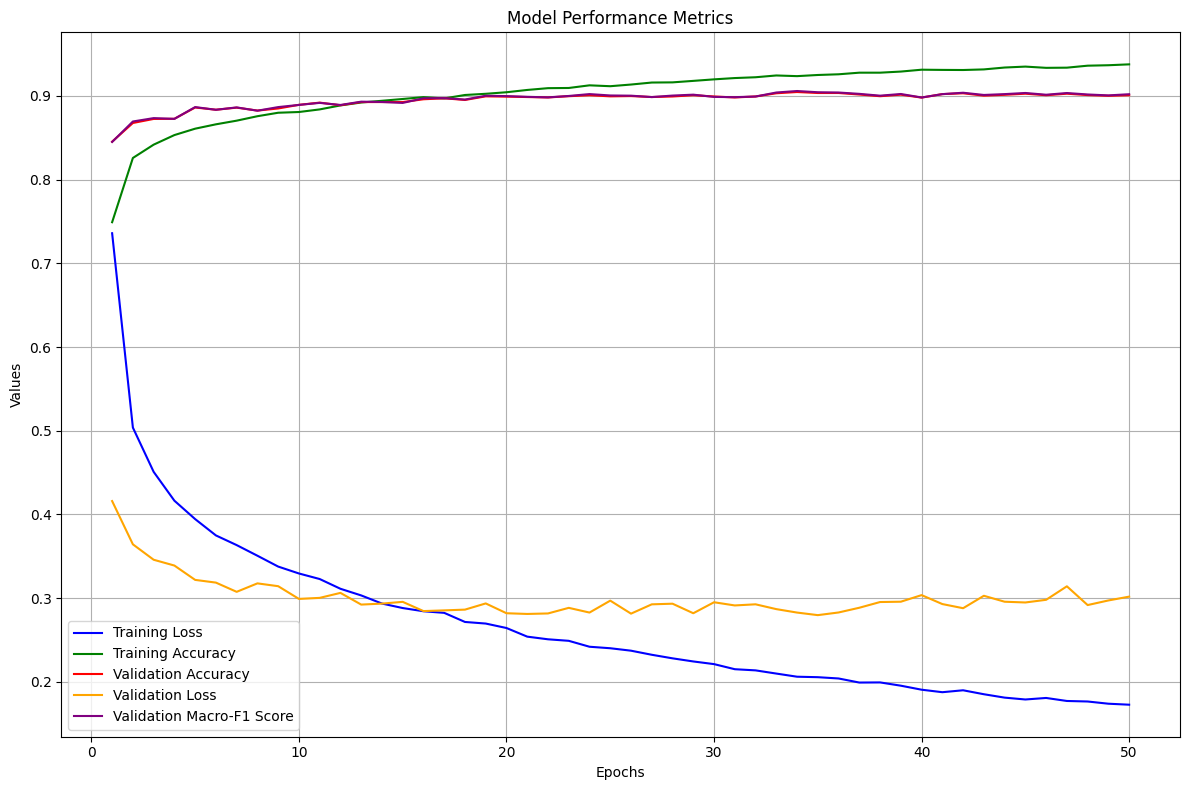

Val Loss: 0.3018, Val Accuracy: 0.9008, Val Macro F1: 0.9020
Confusion Matrix:
[[518   1   9  12   2   0  54   0   1   0]
 [  1 600   0   6   1   0   0   0   0   0]
 [ 17   0 520   3  37   0  34   0   0   0]
 [ 17   1   5 527  26   0   9   0   2   0]
 [  0   0  32  15 536   0  40   1   3   0]
 [  0   0   0   0   0 593   0  21   0   7]
 [ 74   1  47  11  29   0 452   0   5   0]
 [  0   0   0   0   0   6   0 536   0   8]
 [  2   2   5   0   9   1   9   1 561   0]
 [  0   0   0   0   0   6   0  22   0 562]]
Trying configuration: {'learning_rate': 1e-05, 'num_epochs': 50, 'batch_size': 32, 'hidden_layers': [{'size': 512, 'bn': True, 'dropout': 0.3, 'relu': True}, {'size': 256, 'bn': False, 'dropout': 0.4, 'relu': True}, {'size': 128, 'bn': True, 'dropout': 0.5, 'relu': True}]}


100%|██████████| 1687/1687 [00:45<00:00, 36.85it/s]


Epoch 1/50, Train Loss: 2.1229, Train Accuracy: 0.3096, Val Loss: 1.0281, Val Accuracy: 0.7188, Val Macro F1: 0.7121


100%|██████████| 1687/1687 [00:52<00:00, 31.91it/s]


Epoch 2/50, Train Loss: 1.3783, Train Accuracy: 0.5384, Val Loss: 0.8034, Val Accuracy: 0.7568, Val Macro F1: 0.7534


100%|██████████| 1687/1687 [00:45<00:00, 36.86it/s]


Epoch 3/50, Train Loss: 1.1301, Train Accuracy: 0.6265, Val Loss: 0.7063, Val Accuracy: 0.7733, Val Macro F1: 0.7717


100%|██████████| 1687/1687 [00:45<00:00, 36.72it/s]


Epoch 4/50, Train Loss: 1.0006, Train Accuracy: 0.6654, Val Loss: 0.6384, Val Accuracy: 0.7850, Val Macro F1: 0.7847


100%|██████████| 1687/1687 [00:51<00:00, 32.46it/s]


Epoch 5/50, Train Loss: 0.9148, Train Accuracy: 0.6941, Val Loss: 0.5987, Val Accuracy: 0.7960, Val Macro F1: 0.7976


100%|██████████| 1687/1687 [00:45<00:00, 37.00it/s]


Epoch 6/50, Train Loss: 0.8484, Train Accuracy: 0.7172, Val Loss: 0.5572, Val Accuracy: 0.8067, Val Macro F1: 0.8066


100%|██████████| 1687/1687 [00:45<00:00, 36.85it/s]


Epoch 7/50, Train Loss: 0.7969, Train Accuracy: 0.7323, Val Loss: 0.5275, Val Accuracy: 0.8152, Val Macro F1: 0.8155


100%|██████████| 1687/1687 [00:51<00:00, 32.61it/s]


Epoch 8/50, Train Loss: 0.7633, Train Accuracy: 0.7442, Val Loss: 0.5104, Val Accuracy: 0.8205, Val Macro F1: 0.8222


100%|██████████| 1687/1687 [00:45<00:00, 36.83it/s]


Epoch 9/50, Train Loss: 0.7316, Train Accuracy: 0.7535, Val Loss: 0.4916, Val Accuracy: 0.8267, Val Macro F1: 0.8278


100%|██████████| 1687/1687 [00:44<00:00, 37.53it/s]


Epoch 10/50, Train Loss: 0.7044, Train Accuracy: 0.7652, Val Loss: 0.4794, Val Accuracy: 0.8323, Val Macro F1: 0.8335


100%|██████████| 1687/1687 [00:52<00:00, 32.18it/s]


Epoch 11/50, Train Loss: 0.6792, Train Accuracy: 0.7700, Val Loss: 0.4602, Val Accuracy: 0.8330, Val Macro F1: 0.8347


100%|██████████| 1687/1687 [00:47<00:00, 35.67it/s]


Epoch 12/50, Train Loss: 0.6575, Train Accuracy: 0.7790, Val Loss: 0.4562, Val Accuracy: 0.8358, Val Macro F1: 0.8373


100%|██████████| 1687/1687 [00:46<00:00, 35.98it/s]


Epoch 13/50, Train Loss: 0.6483, Train Accuracy: 0.7847, Val Loss: 0.4447, Val Accuracy: 0.8407, Val Macro F1: 0.8426


100%|██████████| 1687/1687 [00:50<00:00, 33.49it/s]


Epoch 14/50, Train Loss: 0.6281, Train Accuracy: 0.7879, Val Loss: 0.4347, Val Accuracy: 0.8475, Val Macro F1: 0.8482


100%|██████████| 1687/1687 [00:49<00:00, 34.22it/s]


Epoch 15/50, Train Loss: 0.6144, Train Accuracy: 0.7945, Val Loss: 0.4269, Val Accuracy: 0.8473, Val Macro F1: 0.8482


100%|██████████| 1687/1687 [00:45<00:00, 36.71it/s]


Epoch 16/50, Train Loss: 0.6027, Train Accuracy: 0.7959, Val Loss: 0.4239, Val Accuracy: 0.8485, Val Macro F1: 0.8511


100%|██████████| 1687/1687 [00:50<00:00, 33.54it/s]


Epoch 17/50, Train Loss: 0.5915, Train Accuracy: 0.8015, Val Loss: 0.4131, Val Accuracy: 0.8527, Val Macro F1: 0.8540


100%|██████████| 1687/1687 [00:47<00:00, 35.23it/s]


Epoch 18/50, Train Loss: 0.5837, Train Accuracy: 0.8030, Val Loss: 0.4105, Val Accuracy: 0.8520, Val Macro F1: 0.8539


100%|██████████| 1687/1687 [00:45<00:00, 37.06it/s]


Epoch 19/50, Train Loss: 0.5755, Train Accuracy: 0.8064, Val Loss: 0.4050, Val Accuracy: 0.8547, Val Macro F1: 0.8569


100%|██████████| 1687/1687 [00:47<00:00, 35.76it/s]


Epoch 20/50, Train Loss: 0.5584, Train Accuracy: 0.8108, Val Loss: 0.3957, Val Accuracy: 0.8562, Val Macro F1: 0.8577


100%|██████████| 1687/1687 [00:46<00:00, 36.04it/s]


Epoch 21/50, Train Loss: 0.5598, Train Accuracy: 0.8112, Val Loss: 0.3935, Val Accuracy: 0.8590, Val Macro F1: 0.8606


100%|██████████| 1687/1687 [00:46<00:00, 36.20it/s]


Epoch 22/50, Train Loss: 0.5473, Train Accuracy: 0.8157, Val Loss: 0.3903, Val Accuracy: 0.8582, Val Macro F1: 0.8600


100%|██████████| 1687/1687 [00:52<00:00, 32.35it/s]


Epoch 23/50, Train Loss: 0.5431, Train Accuracy: 0.8153, Val Loss: 0.3888, Val Accuracy: 0.8587, Val Macro F1: 0.8599


100%|██████████| 1687/1687 [00:46<00:00, 36.13it/s]


Epoch 24/50, Train Loss: 0.5355, Train Accuracy: 0.8184, Val Loss: 0.3837, Val Accuracy: 0.8645, Val Macro F1: 0.8657


100%|██████████| 1687/1687 [00:46<00:00, 36.02it/s]


Epoch 25/50, Train Loss: 0.5300, Train Accuracy: 0.8203, Val Loss: 0.3790, Val Accuracy: 0.8637, Val Macro F1: 0.8653


100%|██████████| 1687/1687 [00:48<00:00, 34.64it/s]


Epoch 26/50, Train Loss: 0.5191, Train Accuracy: 0.8207, Val Loss: 0.3760, Val Accuracy: 0.8628, Val Macro F1: 0.8639


100%|██████████| 1687/1687 [00:45<00:00, 37.06it/s]


Epoch 27/50, Train Loss: 0.5167, Train Accuracy: 0.8232, Val Loss: 0.3717, Val Accuracy: 0.8647, Val Macro F1: 0.8656


100%|██████████| 1687/1687 [00:50<00:00, 33.29it/s]


Epoch 28/50, Train Loss: 0.5096, Train Accuracy: 0.8253, Val Loss: 0.3726, Val Accuracy: 0.8628, Val Macro F1: 0.8647


100%|██████████| 1687/1687 [00:51<00:00, 32.47it/s]


Epoch 29/50, Train Loss: 0.5054, Train Accuracy: 0.8269, Val Loss: 0.3670, Val Accuracy: 0.8668, Val Macro F1: 0.8682


100%|██████████| 1687/1687 [00:47<00:00, 35.30it/s]


Epoch 30/50, Train Loss: 0.5001, Train Accuracy: 0.8291, Val Loss: 0.3649, Val Accuracy: 0.8640, Val Macro F1: 0.8655


100%|██████████| 1687/1687 [00:45<00:00, 36.81it/s]


Epoch 31/50, Train Loss: 0.4980, Train Accuracy: 0.8269, Val Loss: 0.3650, Val Accuracy: 0.8690, Val Macro F1: 0.8699


100%|██████████| 1687/1687 [00:47<00:00, 35.52it/s]


Epoch 32/50, Train Loss: 0.4916, Train Accuracy: 0.8321, Val Loss: 0.3608, Val Accuracy: 0.8675, Val Macro F1: 0.8686


100%|██████████| 1687/1687 [00:46<00:00, 36.66it/s]


Epoch 33/50, Train Loss: 0.4857, Train Accuracy: 0.8336, Val Loss: 0.3574, Val Accuracy: 0.8685, Val Macro F1: 0.8701


100%|██████████| 1687/1687 [00:53<00:00, 31.47it/s]


Epoch 34/50, Train Loss: 0.4799, Train Accuracy: 0.8353, Val Loss: 0.3597, Val Accuracy: 0.8660, Val Macro F1: 0.8680


100%|██████████| 1687/1687 [00:45<00:00, 37.00it/s]


Epoch 35/50, Train Loss: 0.4763, Train Accuracy: 0.8370, Val Loss: 0.3545, Val Accuracy: 0.8695, Val Macro F1: 0.8710


100%|██████████| 1687/1687 [00:45<00:00, 37.18it/s]


Epoch 36/50, Train Loss: 0.4692, Train Accuracy: 0.8395, Val Loss: 0.3544, Val Accuracy: 0.8690, Val Macro F1: 0.8708


100%|██████████| 1687/1687 [00:46<00:00, 36.01it/s]


Epoch 37/50, Train Loss: 0.4681, Train Accuracy: 0.8396, Val Loss: 0.3557, Val Accuracy: 0.8692, Val Macro F1: 0.8709


100%|██████████| 1687/1687 [00:45<00:00, 36.80it/s]


Epoch 38/50, Train Loss: 0.4644, Train Accuracy: 0.8397, Val Loss: 0.3486, Val Accuracy: 0.8718, Val Macro F1: 0.8726


100%|██████████| 1687/1687 [00:46<00:00, 36.60it/s]


Epoch 39/50, Train Loss: 0.4605, Train Accuracy: 0.8408, Val Loss: 0.3458, Val Accuracy: 0.8728, Val Macro F1: 0.8744


100%|██████████| 1687/1687 [00:53<00:00, 31.66it/s]


Epoch 40/50, Train Loss: 0.4580, Train Accuracy: 0.8419, Val Loss: 0.3464, Val Accuracy: 0.8757, Val Macro F1: 0.8776


100%|██████████| 1687/1687 [00:46<00:00, 36.41it/s]


Epoch 41/50, Train Loss: 0.4524, Train Accuracy: 0.8438, Val Loss: 0.3449, Val Accuracy: 0.8730, Val Macro F1: 0.8747


100%|██████████| 1687/1687 [00:46<00:00, 36.61it/s]


Epoch 42/50, Train Loss: 0.4519, Train Accuracy: 0.8454, Val Loss: 0.3455, Val Accuracy: 0.8750, Val Macro F1: 0.8765


100%|██████████| 1687/1687 [00:45<00:00, 36.74it/s]


Epoch 43/50, Train Loss: 0.4447, Train Accuracy: 0.8459, Val Loss: 0.3426, Val Accuracy: 0.8728, Val Macro F1: 0.8750


100%|██████████| 1687/1687 [00:46<00:00, 36.18it/s]


Epoch 44/50, Train Loss: 0.4464, Train Accuracy: 0.8456, Val Loss: 0.3406, Val Accuracy: 0.8753, Val Macro F1: 0.8771


100%|██████████| 1687/1687 [00:48<00:00, 34.86it/s]


Epoch 45/50, Train Loss: 0.4451, Train Accuracy: 0.8458, Val Loss: 0.3376, Val Accuracy: 0.8758, Val Macro F1: 0.8770


100%|██████████| 1687/1687 [00:49<00:00, 33.86it/s]


Epoch 46/50, Train Loss: 0.4366, Train Accuracy: 0.8492, Val Loss: 0.3390, Val Accuracy: 0.8765, Val Macro F1: 0.8778


100%|██████████| 1687/1687 [00:45<00:00, 36.96it/s]


Epoch 47/50, Train Loss: 0.4406, Train Accuracy: 0.8470, Val Loss: 0.3379, Val Accuracy: 0.8755, Val Macro F1: 0.8769


100%|██████████| 1687/1687 [00:46<00:00, 36.04it/s]


Epoch 48/50, Train Loss: 0.4347, Train Accuracy: 0.8514, Val Loss: 0.3322, Val Accuracy: 0.8775, Val Macro F1: 0.8784


100%|██████████| 1687/1687 [00:46<00:00, 36.34it/s]


Epoch 49/50, Train Loss: 0.4317, Train Accuracy: 0.8496, Val Loss: 0.3346, Val Accuracy: 0.8767, Val Macro F1: 0.8782


100%|██████████| 1687/1687 [00:47<00:00, 35.88it/s]


Epoch 50/50, Train Loss: 0.4290, Train Accuracy: 0.8530, Val Loss: 0.3324, Val Accuracy: 0.8810, Val Macro F1: 0.8822
For configuration: {'learning_rate': 1e-05, 'num_epochs': 50, 'batch_size': 32, 'hidden_layers': [{'size': 512, 'bn': True, 'dropout': 0.3, 'relu': True}, {'size': 256, 'bn': False, 'dropout': 0.4, 'relu': True}, {'size': 128, 'bn': True, 'dropout': 0.5, 'relu': True}]}


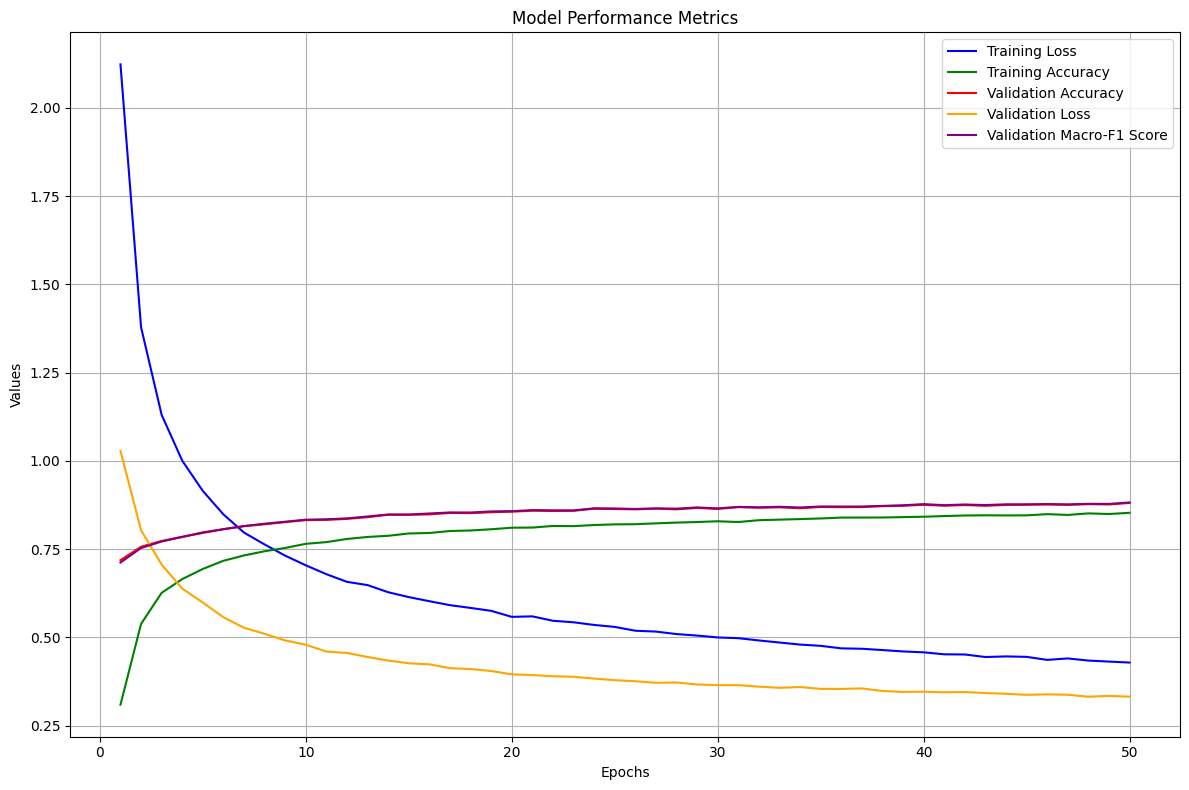

Val Loss: 0.3324, Val Accuracy: 0.8810, Val Macro F1: 0.8822
Confusion Matrix:
[[497   0  15  23   3   0  58   0   1   0]
 [  1 589   2  15   1   0   0   0   0   0]
 [  9   0 495   4  67   0  36   0   0   0]
 [ 16   2   4 529  26   0   9   0   1   0]
 [  0   0  41  13 531   0  39   0   3   0]
 [  0   0   0   0   0 599   0  15   1   6]
 [ 75   0  51  18  54   0 414   0   7   0]
 [  0   0   0   0   0  18   0 518   0  14]
 [  0   1   4   4   4   3  15   3 556   0]
 [  0   0   0   0   0   8   1  23   0 558]]
Plot:


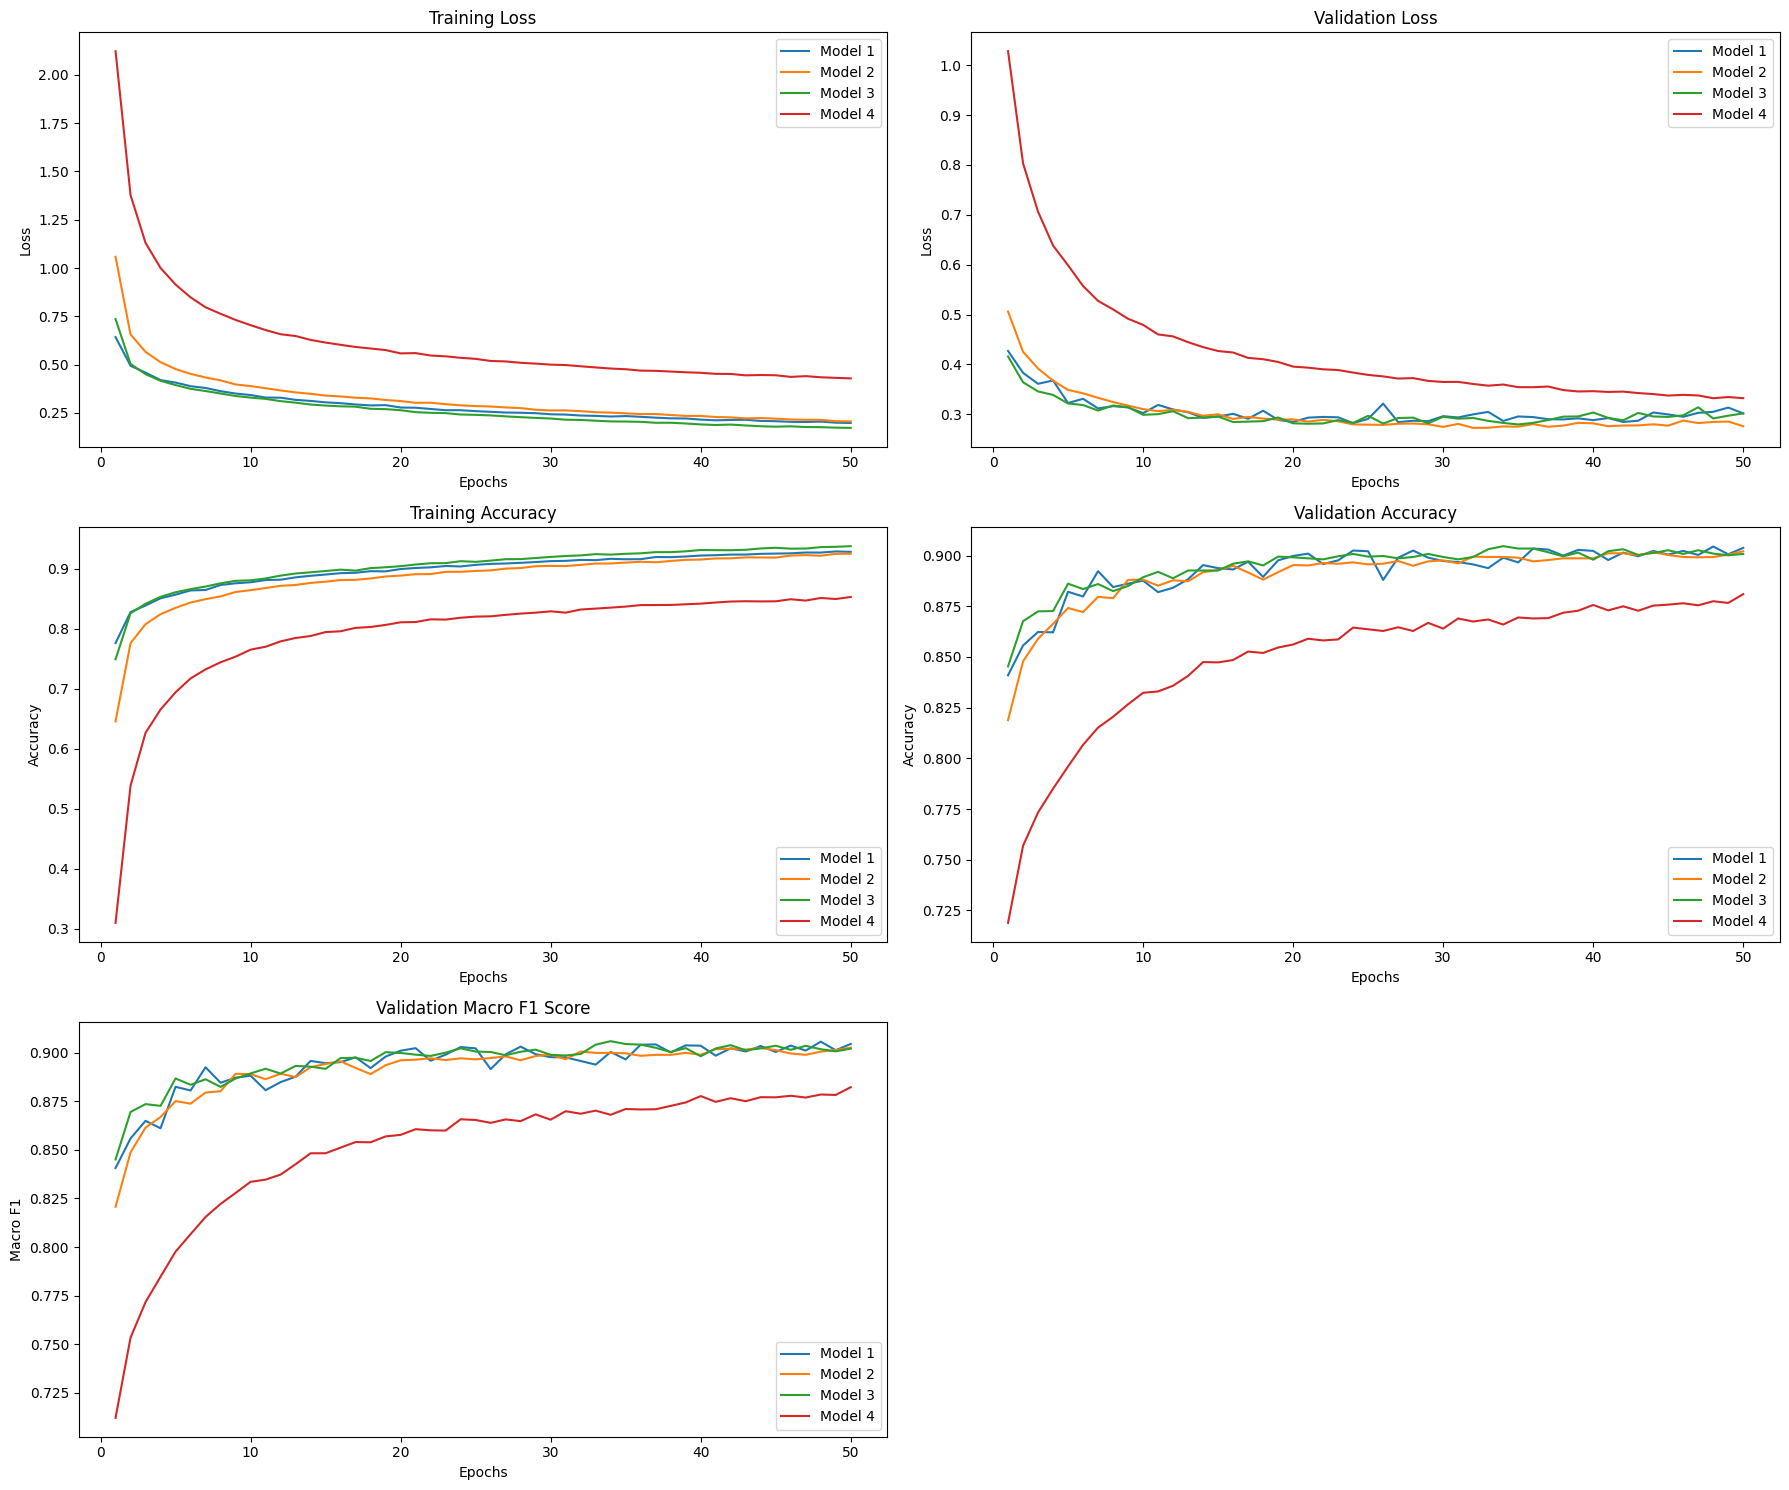

In [33]:
configs = [config_model_1, config_model_2, config_model_3,config_model_4]
best_model, best_config, best_f1 = train_and_evaluate_models(configs,X_train, y_train_one_hot, X_val, y_val_one_hot,y_val_labels,best_f1,best_model,best_config)

In [34]:
print("Best Config:")
print(best_config)

Best Config:
{'learning_rate': 0.005, 'num_epochs': 50, 'batch_size': 32, 'hidden_layers': [{'size': 512, 'bn': True, 'dropout': 0.3, 'relu': True}, {'size': 256, 'bn': False, 'dropout': 0.4, 'relu': True}, {'size': 128, 'bn': True, 'dropout': 0.5, 'relu': True}]}


In [35]:
print("Best Val Macro F1:")
print(best_f1)

Best Val Macro F1:
0.9044309946645397


# Train and Save Best model

In [36]:
X_train_merged = np.concatenate([X_train, X_val], axis=0)
y_train_one_hot_merged = np.concatenate([y_train_one_hot, y_val_one_hot], axis=0)
y_train_labels_merged = np.concatenate([y_train_labels, y_val_labels], axis=0)

In [37]:
best_model = build_model(best_config)

In [38]:
best_model.fit(X_train_merged, y_train_one_hot_merged)

100%|██████████| 1875/1875 [00:51<00:00, 36.18it/s]


Epoch 1/50, Train Loss: 0.6334, Train Accuracy: 0.7794


100%|██████████| 1875/1875 [00:52<00:00, 35.42it/s]


Epoch 2/50, Train Loss: 0.4863, Train Accuracy: 0.8315


100%|██████████| 1875/1875 [00:51<00:00, 36.41it/s]


Epoch 3/50, Train Loss: 0.4516, Train Accuracy: 0.8424


100%|██████████| 1875/1875 [00:53<00:00, 35.33it/s]


Epoch 4/50, Train Loss: 0.4224, Train Accuracy: 0.8519


100%|██████████| 1875/1875 [01:01<00:00, 30.56it/s]


Epoch 5/50, Train Loss: 0.4000, Train Accuracy: 0.8619


100%|██████████| 1875/1875 [00:55<00:00, 34.07it/s]


Epoch 6/50, Train Loss: 0.3840, Train Accuracy: 0.8650


100%|██████████| 1875/1875 [00:54<00:00, 34.60it/s]


Epoch 7/50, Train Loss: 0.3686, Train Accuracy: 0.8711


100%|██████████| 1875/1875 [00:54<00:00, 34.31it/s]


Epoch 8/50, Train Loss: 0.3581, Train Accuracy: 0.8736


100%|██████████| 1875/1875 [00:54<00:00, 34.52it/s]


Epoch 9/50, Train Loss: 0.3439, Train Accuracy: 0.8784


100%|██████████| 1875/1875 [01:02<00:00, 30.12it/s]


Epoch 10/50, Train Loss: 0.3381, Train Accuracy: 0.8793


100%|██████████| 1875/1875 [00:57<00:00, 32.68it/s]


Epoch 11/50, Train Loss: 0.3316, Train Accuracy: 0.8813


100%|██████████| 1875/1875 [00:57<00:00, 32.35it/s]


Epoch 12/50, Train Loss: 0.3242, Train Accuracy: 0.8849


100%|██████████| 1875/1875 [00:58<00:00, 32.02it/s]


Epoch 13/50, Train Loss: 0.3124, Train Accuracy: 0.8887


100%|██████████| 1875/1875 [00:59<00:00, 31.63it/s]


Epoch 14/50, Train Loss: 0.3104, Train Accuracy: 0.8876


100%|██████████| 1875/1875 [01:08<00:00, 27.30it/s]


Epoch 15/50, Train Loss: 0.3052, Train Accuracy: 0.8910


100%|██████████| 1875/1875 [00:59<00:00, 31.54it/s]


Epoch 16/50, Train Loss: 0.3003, Train Accuracy: 0.8944


100%|██████████| 1875/1875 [00:59<00:00, 31.31it/s]


Epoch 17/50, Train Loss: 0.2936, Train Accuracy: 0.8948


100%|██████████| 1875/1875 [01:00<00:00, 30.81it/s]


Epoch 18/50, Train Loss: 0.2880, Train Accuracy: 0.8977


100%|██████████| 1875/1875 [01:09<00:00, 26.98it/s]


Epoch 19/50, Train Loss: 0.2813, Train Accuracy: 0.8995


100%|██████████| 1875/1875 [01:04<00:00, 29.13it/s]


Epoch 20/50, Train Loss: 0.2806, Train Accuracy: 0.8984


100%|██████████| 1875/1875 [01:04<00:00, 29.12it/s]


Epoch 21/50, Train Loss: 0.2726, Train Accuracy: 0.9020


100%|██████████| 1875/1875 [01:02<00:00, 29.80it/s]


Epoch 22/50, Train Loss: 0.2688, Train Accuracy: 0.9019


100%|██████████| 1875/1875 [01:09<00:00, 26.81it/s]


Epoch 23/50, Train Loss: 0.2656, Train Accuracy: 0.9038


100%|██████████| 1875/1875 [01:05<00:00, 28.66it/s]


Epoch 24/50, Train Loss: 0.2647, Train Accuracy: 0.9045


100%|██████████| 1875/1875 [01:04<00:00, 29.08it/s]


Epoch 25/50, Train Loss: 0.2607, Train Accuracy: 0.9072


100%|██████████| 1875/1875 [01:04<00:00, 29.05it/s]


Epoch 26/50, Train Loss: 0.2572, Train Accuracy: 0.9060


100%|██████████| 1875/1875 [01:07<00:00, 27.71it/s]


Epoch 27/50, Train Loss: 0.2524, Train Accuracy: 0.9097


100%|██████████| 1875/1875 [01:07<00:00, 27.89it/s]


Epoch 28/50, Train Loss: 0.2523, Train Accuracy: 0.9087


100%|██████████| 1875/1875 [01:04<00:00, 28.93it/s]


Epoch 29/50, Train Loss: 0.2460, Train Accuracy: 0.9102


100%|██████████| 1875/1875 [01:06<00:00, 28.36it/s]


Epoch 30/50, Train Loss: 0.2495, Train Accuracy: 0.9114


100%|██████████| 1875/1875 [01:08<00:00, 27.51it/s]


Epoch 31/50, Train Loss: 0.2396, Train Accuracy: 0.9128


100%|██████████| 1875/1875 [01:11<00:00, 26.12it/s]


Epoch 32/50, Train Loss: 0.2400, Train Accuracy: 0.9142


100%|██████████| 1875/1875 [01:06<00:00, 28.16it/s]


Epoch 33/50, Train Loss: 0.2373, Train Accuracy: 0.9129


100%|██████████| 1875/1875 [01:06<00:00, 28.17it/s]


Epoch 34/50, Train Loss: 0.2316, Train Accuracy: 0.9159


100%|██████████| 1875/1875 [01:08<00:00, 27.29it/s]


Epoch 35/50, Train Loss: 0.2303, Train Accuracy: 0.9176


100%|██████████| 1875/1875 [01:13<00:00, 25.60it/s]


Epoch 36/50, Train Loss: 0.2303, Train Accuracy: 0.9163


100%|██████████| 1875/1875 [01:06<00:00, 28.05it/s]


Epoch 37/50, Train Loss: 0.2265, Train Accuracy: 0.9192


100%|██████████| 1875/1875 [01:06<00:00, 28.22it/s]


Epoch 38/50, Train Loss: 0.2259, Train Accuracy: 0.9179


100%|██████████| 1875/1875 [01:08<00:00, 27.30it/s]


Epoch 39/50, Train Loss: 0.2205, Train Accuracy: 0.9212


100%|██████████| 1875/1875 [01:13<00:00, 25.38it/s]


Epoch 40/50, Train Loss: 0.2237, Train Accuracy: 0.9199


100%|██████████| 1875/1875 [01:06<00:00, 28.06it/s]


Epoch 41/50, Train Loss: 0.2150, Train Accuracy: 0.9222


100%|██████████| 1875/1875 [01:07<00:00, 27.84it/s]


Epoch 42/50, Train Loss: 0.2169, Train Accuracy: 0.9241


100%|██████████| 1875/1875 [01:10<00:00, 26.79it/s]


Epoch 43/50, Train Loss: 0.2150, Train Accuracy: 0.9221


100%|██████████| 1875/1875 [01:13<00:00, 25.42it/s]


Epoch 44/50, Train Loss: 0.2134, Train Accuracy: 0.9230


100%|██████████| 1875/1875 [01:08<00:00, 27.22it/s]


Epoch 45/50, Train Loss: 0.2117, Train Accuracy: 0.9241


100%|██████████| 1875/1875 [01:07<00:00, 27.69it/s]


Epoch 46/50, Train Loss: 0.2066, Train Accuracy: 0.9252


100%|██████████| 1875/1875 [01:08<00:00, 27.29it/s]


Epoch 47/50, Train Loss: 0.2045, Train Accuracy: 0.9270


100%|██████████| 1875/1875 [01:13<00:00, 25.48it/s]


Epoch 48/50, Train Loss: 0.2047, Train Accuracy: 0.9256


100%|██████████| 1875/1875 [01:08<00:00, 27.48it/s]


Epoch 49/50, Train Loss: 0.2019, Train Accuracy: 0.9275


100%|██████████| 1875/1875 [01:06<00:00, 28.05it/s]

Epoch 50/50, Train Loss: 0.1972, Train Accuracy: 0.9283


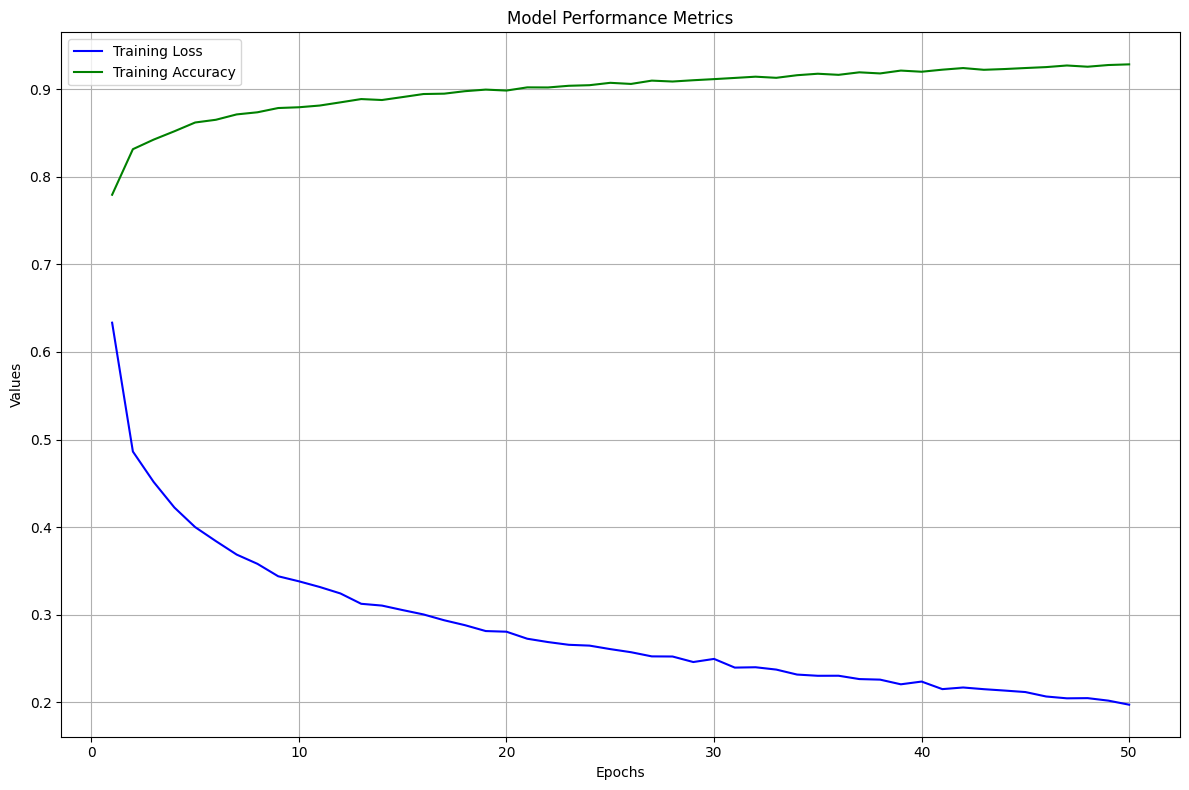

In [39]:
plot_model_history(best_model)

In [40]:
save_model(best_config,best_model,'model_1905113.pkl')

Model saved to model_1905113.pkl


# Load Saved Model 

In [41]:
loaded_model = load_model('model_1905113.pkl')

Model loaded from file


# Independent Testing

**Direct Trained Model**

In [42]:
test_predictions = best_model.predict(X_test)
test_loss, test_acc, test_macro_f1 = best_model.evaluate(X_test, y_test_one_hot)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Macro F1: {test_macro_f1:.4f}")

Test Loss: 0.3026, Test Accuracy: 0.9066, Test Macro F1: 0.9067


In [43]:
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[828   0  11  21   4   1 128   0   7   0]
 [  3 985   1   7   0   0   2   0   2   0]
 [ 15   1 854   7  57   0  65   0   1   0]
 [ 14   7   7 921  31   0  17   0   3   0]
 [  0   0  78  25 834   1  60   0   2   0]
 [  0   0   0   1   0 982   0   9   1   7]
 [ 94   0  59  26  56   0 760   0   5   0]
 [  0   0   0   0   0  19   0 957   0  24]
 [  5   0   5   3   1   3   2   3 978   0]
 [  0   0   0   0   0   8   1  24   0 967]]


**Loaded Model**

In [44]:
test_predictions = loaded_model.predict(X_test)
test_loss, test_acc, test_macro_f1 = loaded_model.evaluate(X_test, y_test_one_hot)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Macro F1: {test_macro_f1:.4f}")

Test Loss: 0.3026, Test Accuracy: 0.9066, Test Macro F1: 0.9067


In [45]:
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[828   0  11  21   4   1 128   0   7   0]
 [  3 985   1   7   0   0   2   0   2   0]
 [ 15   1 854   7  57   0  65   0   1   0]
 [ 14   7   7 921  31   0  17   0   3   0]
 [  0   0  78  25 834   1  60   0   2   0]
 [  0   0   0   1   0 982   0   9   1   7]
 [ 94   0  59  26  56   0 760   0   5   0]
 [  0   0   0   0   0  19   0 957   0  24]
 [  5   0   5   3   1   3   2   3 978   0]
 [  0   0   0   0   0   8   1  24   0 967]]
